<a href="https://colab.research.google.com/github/engomarwasfy/DIP/blob/main/Stereo_Vision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt 
import cv2 as cv
import math
def BGR2RGB (image):
    RGBImage = cv.cvtColor(image,cv.COLOR_BGR2RGB)
    return RGBImage
img1_path='/content/drive/MyDrive/All/omarwasfy/Master2/DIP/Assignment3/view1.png'
img2_path='/content/drive/MyDrive/All/omarwasfy/Master2/DIP/Assignment3/view2.png'

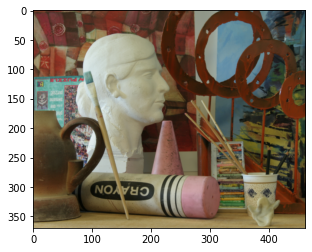

In [ ]:
img1 = cv.imread(img1_path)
img1 = BGR2RGB(img1)
plt.imshow(img1)

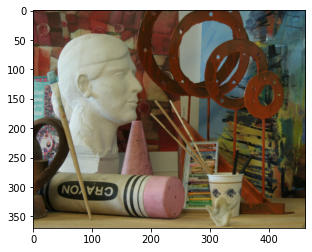

In [ ]:
img2 = cv.imread(img2_path)
img2 = BGR2RGB (img2)
plt.imshow(img2)

## 1 Stereo Vision
 In this part of the assignment you will implement and test some simple stereo algorithms.
In each case you will take two images Il and Ir (a left and a right image) and compute the
horizontal disparity (ie., shift) of pixels along each scanline. This is the so-called baseline stereo
case, where the images are taken with a forward-facing camera, and the translation between
cameras is along the horizontal axis.

##1.1 Block Matching
To get the disparity value at each point in the left image, you will search over a range disparities,
and compare the windows using two different metrics: Sum of Absolute Differences (SAD) and
Sum of Squared Differences. Do this for windows of size w where w = 1, 5 and 9. The disparity,
d.

In [ ]:
# This function computes disparity between two images regardless of left or right as window checks are in both sides ,
#takes a variable window size argument and boolean variable to mark L2 SSD or L2 SAD distance (SSD or SAD ) measures
def compute_Disparity(img1,img2,window_length,L2_Dist):
  half_window_length= (int)(window_length/2);
  img_lft_padded = cv2.copyMakeBorder(img1, half_window_length, half_window_length, half_window_length, half_window_length, cv2.BORDER_CONSTANT, value=0);
  img_rght_padded = cv2.copyMakeBorder(img2,half_window_length,half_window_length,half_window_length,half_window_length, cv2.BORDER_CONSTANT, value=0);
  width, height, z = img_lft_padded.shape
  disp_map_lft = np.zeros((width, height))
  for i in range(half_window_length, width - half_window_length):
      for j in range( half_window_length, height -  half_window_length):
          current_block_lft = img_lft_padded[i - half_window_length:i + half_window_length +1, j- half_window_length:j + half_window_length +1]
          match_lft = 0
          min_ssdlft = math.inf # initialize left image min ssd as maximum value of int in numpy
          for idx in range(j - 75, j + 75):
              # to avoid over-flow error while slicing right view image into blocks
              if idx < window_length:
                  idx = window_length
              elif  idx >= height-window_length:
                  idx =  height-window_length-1
              current_ssd=0
              if (L2_Dist == True):
                current_ssd = np.sum(np.square(np.subtract(current_block_lft, img_rght_padded[i - half_window_length :i + half_window_length + 1, idx - half_window_length :idx + half_window_length + 1])))
              else:
                current_ssd = np.sum(np.abs(np.subtract(current_block_lft, img_rght_padded[i - half_window_length :i + half_window_length + 1, idx - half_window_length :idx + half_window_length + 1])))
              if float(current_ssd) < min_ssdlft:
                  min_ssdlft = current_ssd
                  match_lft = idx
          disp_map_lft[i][j] = abs(j - match_lft)
  plt.figure()
  plt.imshow(disp_map_lft,cmap = 'gray', aspect='auto')
  distanceMeasureName = 'SSD' if L2_Dist == True else 'SAD'
  plt.title('window Length = '+str(window_length) +','+distanceMeasureName)

1-We would note is SSD in general gives smoother disparity map than SAD as SAD measure tend to have sharper disparity maps
2-We would note the effect of increasing window size is like the effect of adding smoothing filter after a smaller window size map generated so disparity map becomes more smoother than before 
Beware that increasing window size is good until we start loosing planer points that are compared inside window size ,If we increased window size alot we would get a completely wrong disparity map, window size choice is dependent on how much area on average tends to have pixels at certain distance from camera so it is one way or another a hyper parameter dependent on the details of objects inside certain photo.

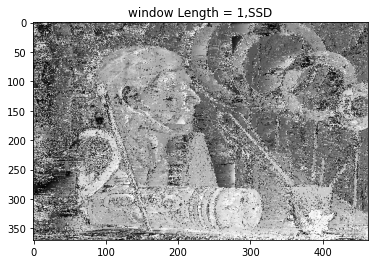

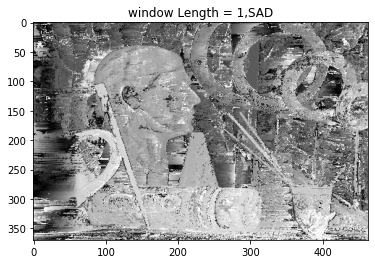

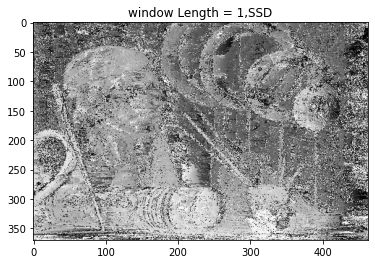

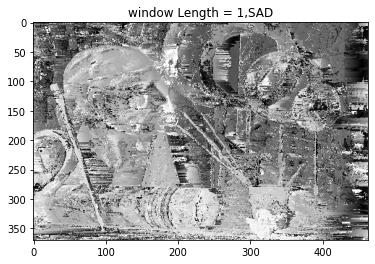

In [ ]:
compute_Disparity(img1,img2,1,True)
compute_Disparity(img1,img2,1,False)
compute_Disparity(img2,img1,1,True)
compute_Disparity(img2,img1,1,False)

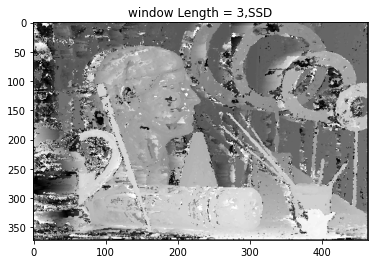

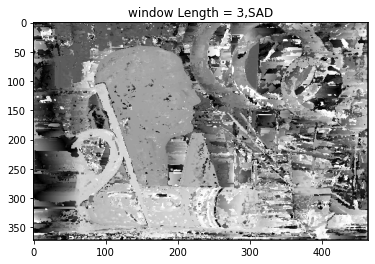

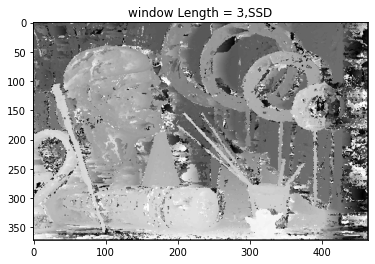

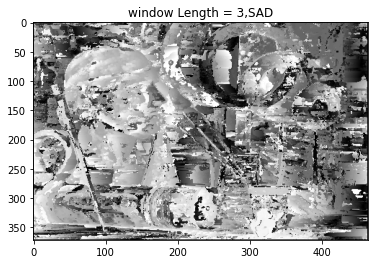

In [ ]:
compute_Disparity(img1,img2,3,True)
compute_Disparity(img1,img2,3,False)
compute_Disparity(img2,img1,3,True)
compute_Disparity(img2,img1,3,False)

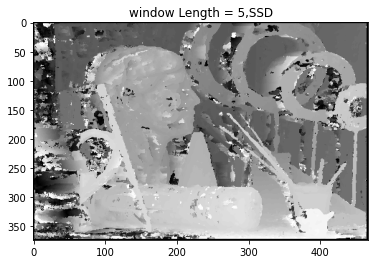

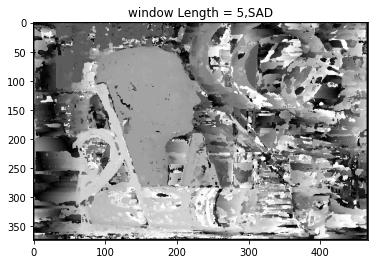

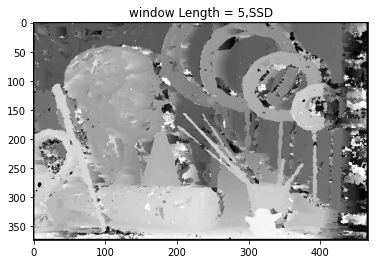

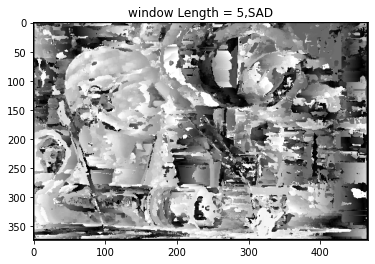

In [ ]:
compute_Disparity(img1,img2,5,True)
compute_Disparity(img1,img2,5,False)
compute_Disparity(img2,img1,5,True)
compute_Disparity(img2,img1,5,False)

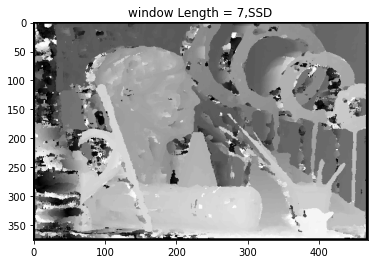

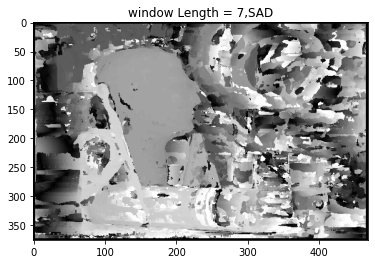

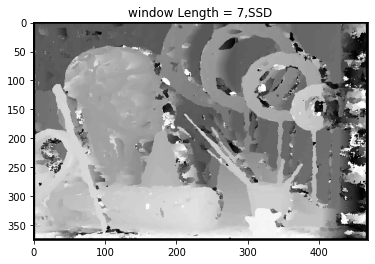

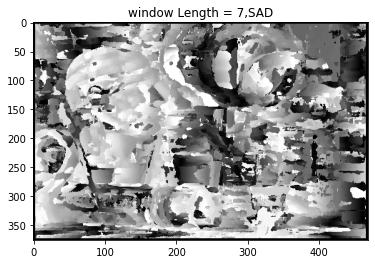

In [ ]:
compute_Disparity(img1,img2,7,True)
compute_Disparity(img1,img2,7,False)
compute_Disparity(img2,img1,7,True)
compute_Disparity(img2,img1,7,False)

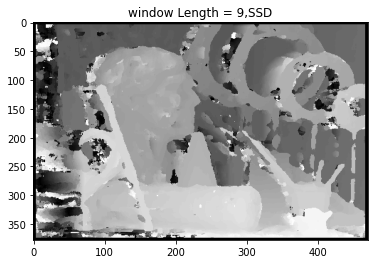

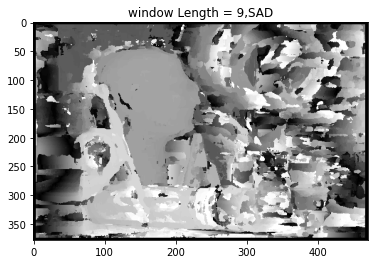

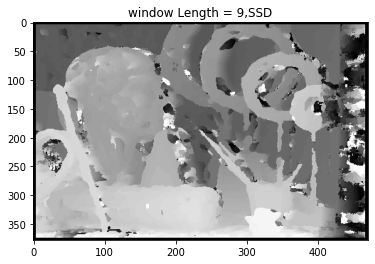

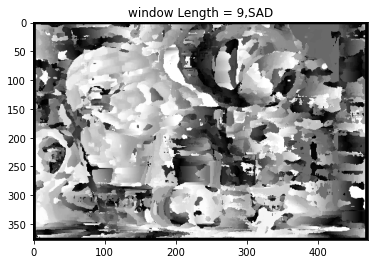

In [ ]:
compute_Disparity(img1,img2,9,True)
compute_Disparity(img1,img2,9,False)
compute_Disparity(img2,img1,9,True)
compute_Disparity(img2,img1,9,False)

##1.2 Dynamic programming
Consider two scanlines Il(i) and Ir(j). Pixels in each scanline may be matched, or skipped
(considered to be occluded in either the left or right image). Let dij be the cost associated with
matching pixel Il(i) with pixel Ir(j). Here we consider a squared error measure between pixels
given by:
dij = (Il(i) − Ir(j))2
σ2
where σ is some measure of pixel noise. The cost of skipping a pixel (in either scanline)
is given by a constant c0 . For the experiments here we will use σ = 2 and c0 = 1. Given
these costs, we can compute the optimal (minimal cost) alignment of two scanlines recursively
as follows:
1. D(1; 1) = d11
2. D(i; j) = min(D(i1; j1) + dij; D(i1; j) + c0; D(i; j1) + c0)
The intermediate values are stored in an N-by-N matrix, D. The total cost of matching two
scanlines is D(N, N ). Note that this assumes the lines are matched at both ends (and hence
have zero disparity there). This is a reasonable approximation provided the images are large
relative to the disparity shift. Given D we find the optimal alignment by backtracking. In
particular, starting at (i; j) = (N; N), we choose the minimum value of D from (i - 1, j - 1),
(i - 1, j), (i, j - 1). Selecting (i - 1, j) corresponds to skipping a pixel in Il (a unit increase
in disparity), while selecting (i, j - 1) corresponds to skipping a pixel in Ir (a unit decrease in disparity). Selecting (i - 1, j - 1) matches pixels (i, j), and therefore leaves disparity unchanged.
Beginning with zero disparity, we can work backwards from (N, N ), tallying the disparity until
we reach (1, 1).
A good way to interpret your solution is to plot the alignment found for single scan line.
To display the alignment plot a graph of Il (horizontal) vs Ir (vertical). Begin at D(N, N ) and
work backwards to find the best path. If a pixel in Il is skipped, draw a horizontal line. If a
pixel in Ir is skipped, draw a vertical line. Otherwise, the pixels are matched, and you draw a
diagonal line. The plot should end at (1, 1).

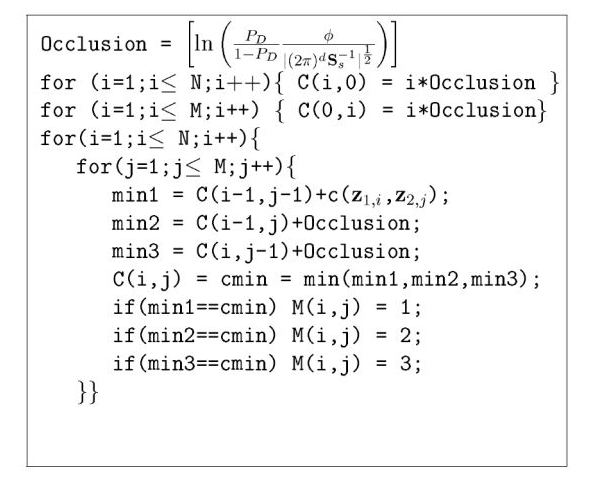

In [ ]:
import numpy as np
import imageio
import cv2
from matplotlib import pyplot as plt
def get_cost(i1,i2,sigma_squared = 4):
  
  return (i1-i2) * (i1-i2)  / (sigma_squared)

def show_results(img1,img2,disparity_Left,disparity_Right):
  plt.figure()
  fig, ((ax1, ax2),(ax3,ax4)) = plt.subplots(nrows=2, ncols=2, constrained_layout=False, figsize=(16,9))
  ax1.imshow(img1, cmap="gray")
  ax1.set_xlabel("Left image")
  ax2.imshow(img2, cmap="gray")
  ax2.set_xlabel("Right Image")

  ax3.imshow(disparity_Left, cmap="gray")
  ax3.set_xlabel("disparity_Left")

  ax4.imshow(disparity_Right, cmap="gray")
  ax4.set_xlabel("disparity_Right")

  plt.show
def get_disparity(img1,img2):
  rows,columns= img1.shape
  print(rows, columns)
  #### Initializations:

  # Constructin matrix for the Intermediate values
  # Columns are also the Number of Pixels in each line
  # The matrix is N x N where N is the number of pixels in each line.
  D = np.empty([columns, columns], dtype=np.float)
  # For path and backtracking.
  M = np.empty([columns, columns], dtype=np.float)

  disparity_Left = np.empty([rows, columns], dtype=np.float)
  disparity_Right = np.empty([rows, columns], dtype=np.float)

  co = 6    # As required 
  cost = 0.0 
  sigma = 2
  simga_squared = 4
  D[0, 0] = 0
  print("Processing..")
  for row in range(0,rows):
    # print("Processing row ",row)

    D[0,0] = get_cost(img1[row, 0] , img2[row, 0])
    for i in range(1, columns):
          D[i, 0] = i * co
          D[0, i] = i * co

    for i in range(0, columns):
      
      for j in range(0, columns):

        # Cost function for matching features in the left and right images
        cost = get_cost(img1[row, i] , img2[row, j])
        
        min1 = D[i-1, j-1] + cost
        min2 = D[i-1, j] + co
        min3 = D[i, j-1] + co

        cmin = min(min1, min2, min3)
        # print(cmin)
        D[i, j] = cmin
        
        # Forming path matrix
        if(cmin == min1):
            M[i, j] = 1
        if(cmin == min2):
            M[i, j] = 2
        if(cmin == min3):
            M[i, j] = 3


    p = columns - 1
    q = columns - 1
    
    #if row == 50:
    plt.figure()
    plt.ylim(i)
    plt.xlim(j)
      
    while(p != 0 and q !=0):
        
        # if feature in left and right image matches
        if(M[p, q] == 1):
            disparity_Left[row, p] = abs(p-q)
            disparity_Right[row, q] = abs(q-p)                

            p = p - 1
            q = q - 1
            # Plot a Diagonal line
            plt.plot( [p,p+1], [q,q+1],color = 'red')

        # if feature in left image is occuluded
        elif(M[p, q] == 2):
            disparity_Left[row, p] = 0
            p = p - 1
             # Draw a Vertical line
            plt.plot( [p,p], [q,q+1],color = 'green')
        # if feature in right image is occuluded
        elif(M[p, q] == 3):
            disparity_Right[row, q] = 0
            q = q - 1
            # Draw a Horizontal line
            plt.plot( [p,p+1], [q,q],color = 'blue')
    plt.title('Dynamic programming matching at row =' +str(row))    
    plt.show()     
    D = np.empty([columns, columns], dtype=np.float)
    M = np.empty([columns, columns], dtype=np.float)
  return cv2.GaussianBlur(disparity_Left,(5,5),0),cv2.GaussianBlur(disparity_Right,(5,5),0)
def load_images(url1,url2,rgb=1):
    original_Left_Image = cv2.imread(url1,rgb)
    original_Right_Image = cv2.imread(url2,rgb)
    if rgb:
      original_Left_Image = cv2.cvtColor(original_Left_Image,cv2.COLOR_RGB2GRAY)
      original_Right_Image = cv2.cvtColor(original_Right_Image,cv2.COLOR_RGB2GRAY)
    original_Left_Image = cv2.GaussianBlur(original_Left_Image,(5,5),0)
    original_Right_Image= cv2.GaussianBlur(original_Right_Image,(5,5),0)
    leftImage = np.asarray(original_Left_Image, dtype = np.float)
    rightImage = np.asarray(original_Right_Image, dtype = np.float)
    return leftImage,rightImage

1-We have plotted a path matrix for all rows inside photos these methods of plottng path of alignment are used in multiple applications ,for example in bioinformatics approximate methods like FASTA and BLAST try to predict this matrix without go to dynamic programming and through only this path map we can predict how much protien sequences are similar to each other , this maps to rows on our problem how they are similar to one another , you will find that all rows despite not Identical but there is a trend towards one transformation they are all similar , If we found a row that is diffrent from all rows by much that mean there is something wrong as the locality of physical objects must imply the similarity between all paths of dynamic programming row graphs.

2-we included an extra gaussian filter knowing that dynamic programming result is affected by photo metric transformation and cost penality so adding gaussian filter step is to normalize our output and make it smoother as we know that the ground truth  would be smoother than the dynamic programming only solution 



370 463
Processing..


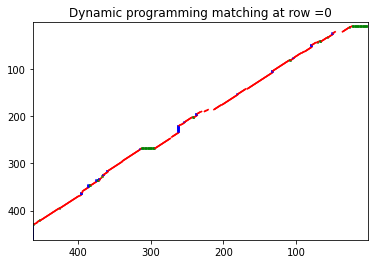

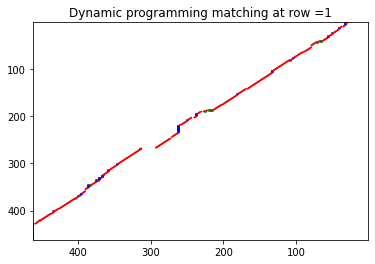

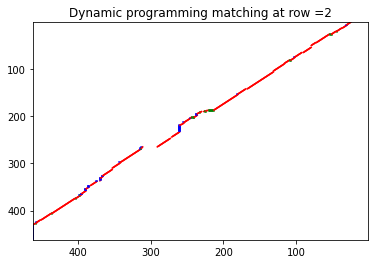

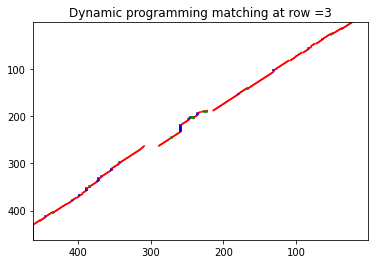

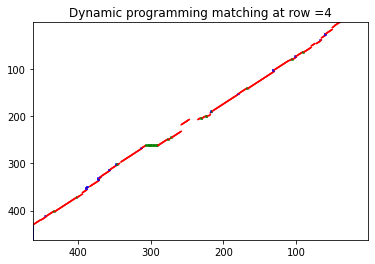

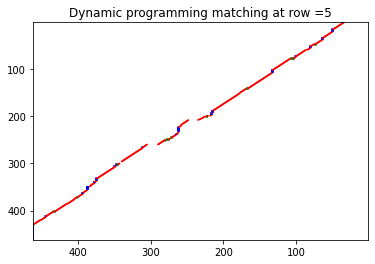

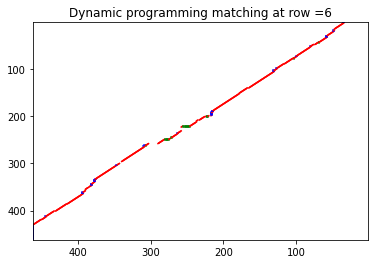

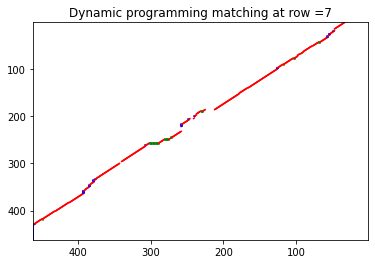

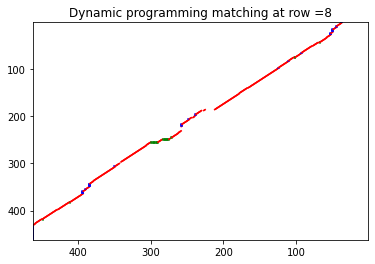

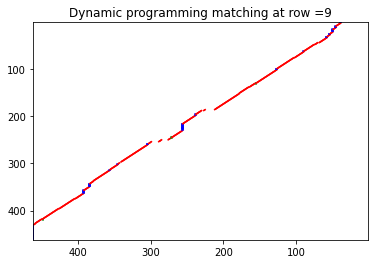

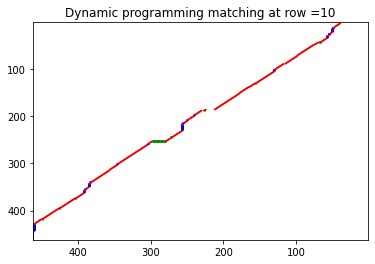

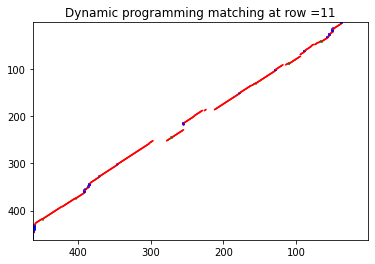

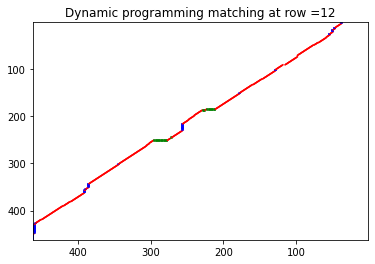

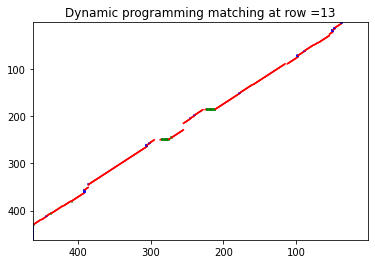

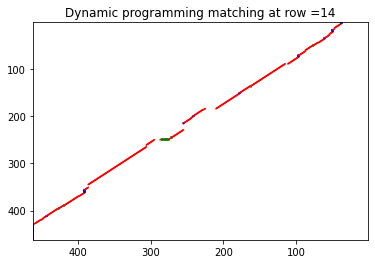

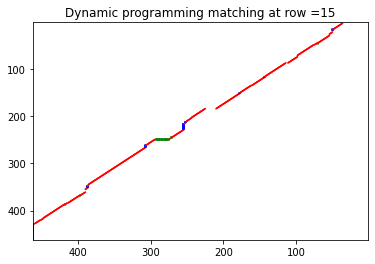

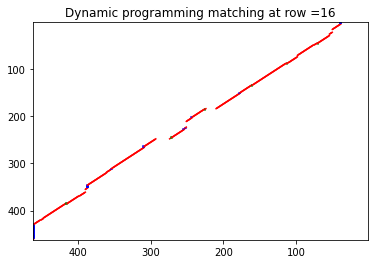

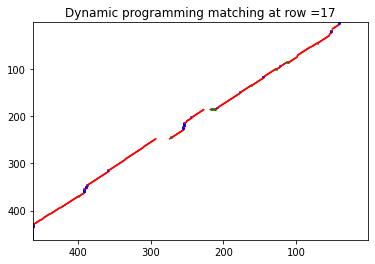

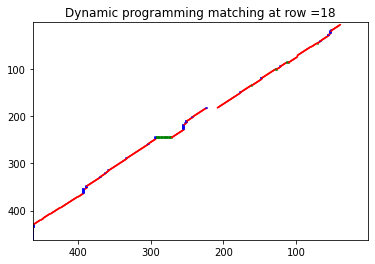

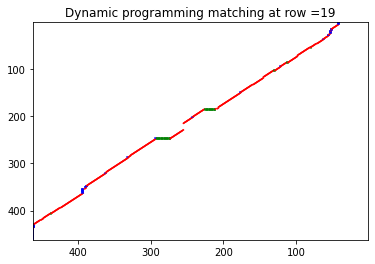

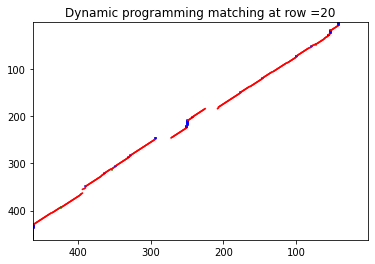

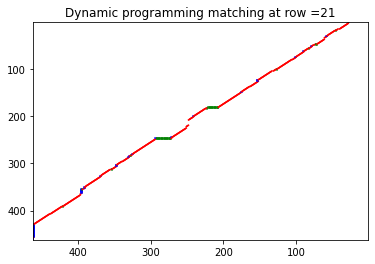

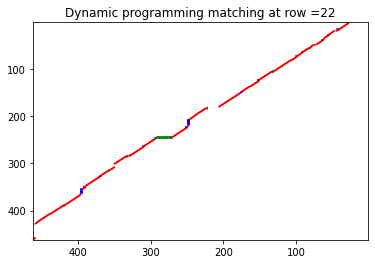

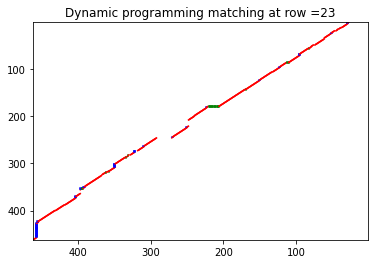

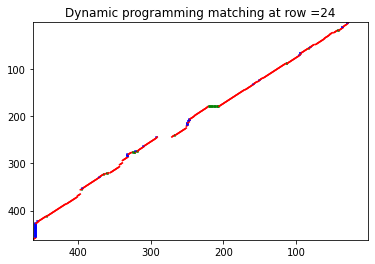

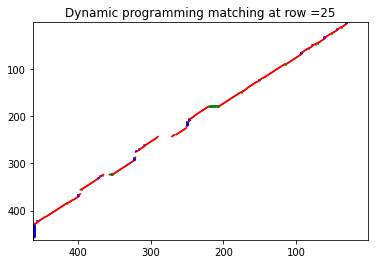

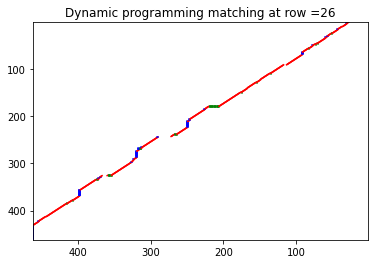

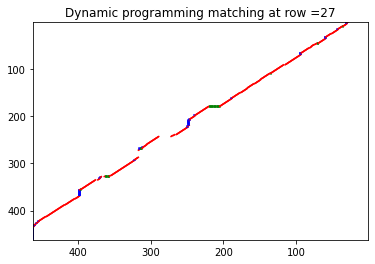

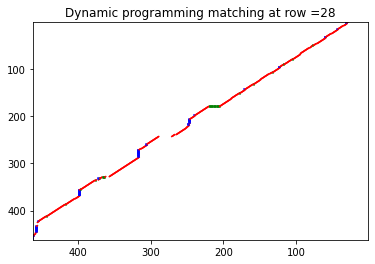

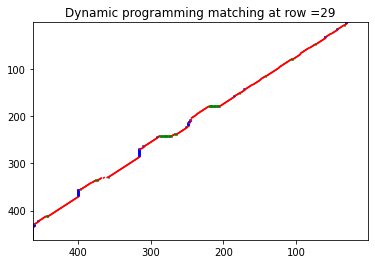

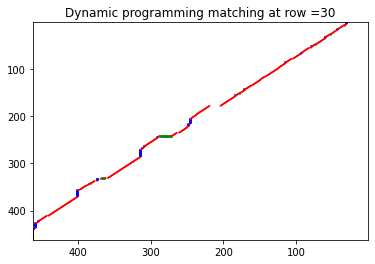

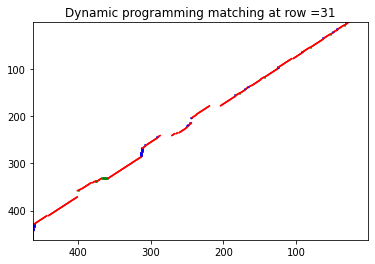

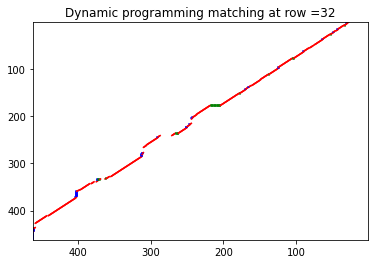

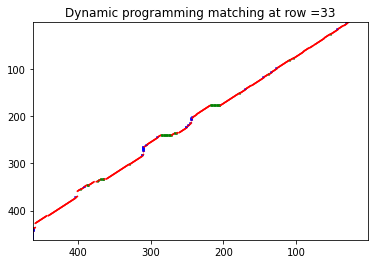

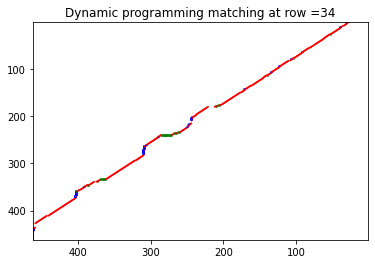

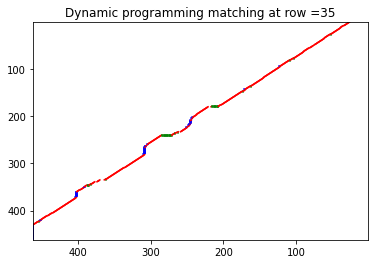

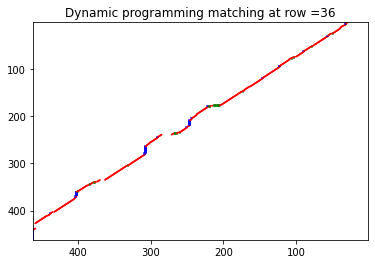

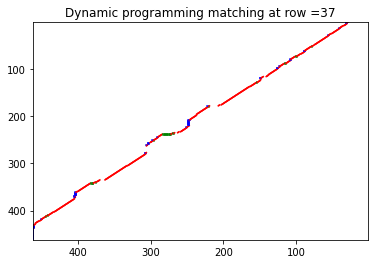

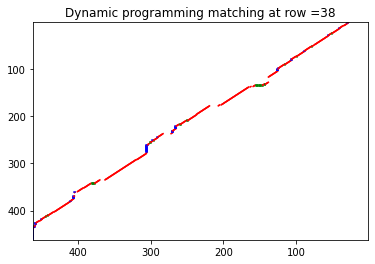

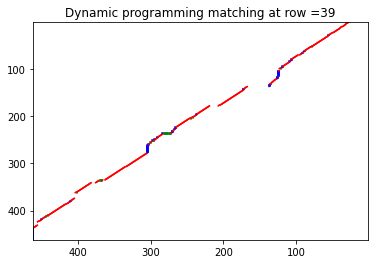

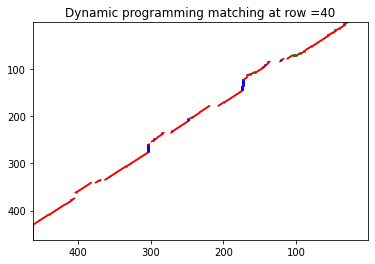

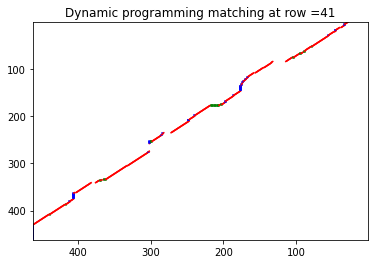

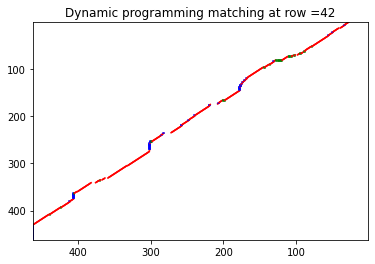

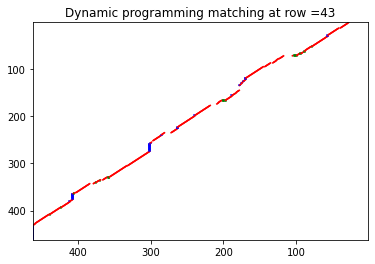

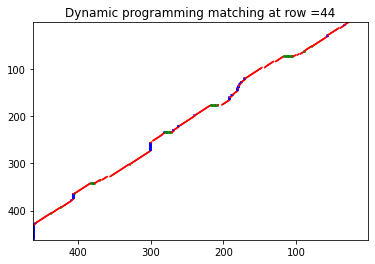

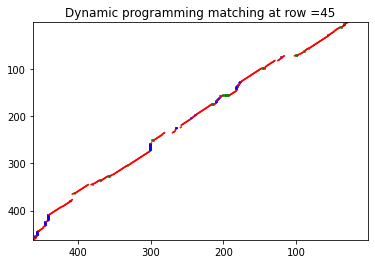

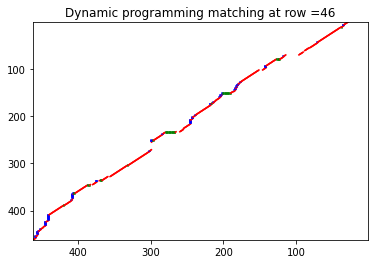

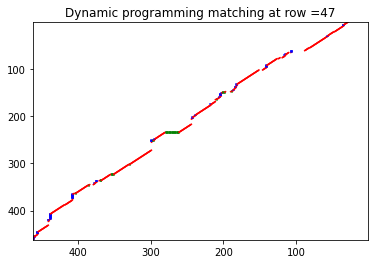

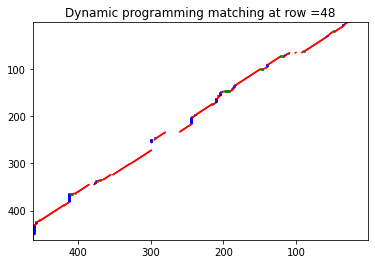

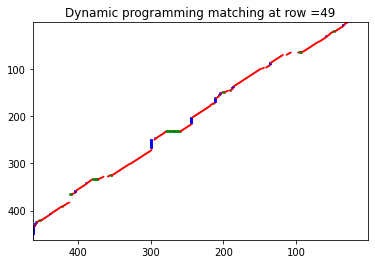

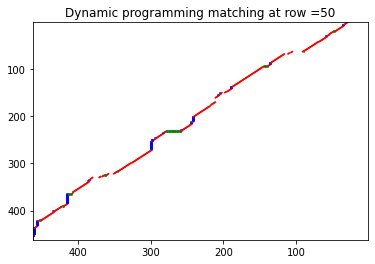

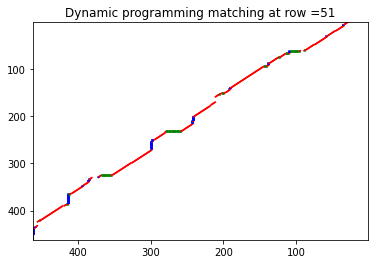

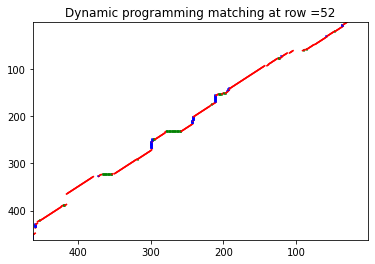

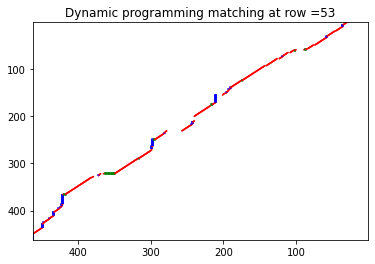

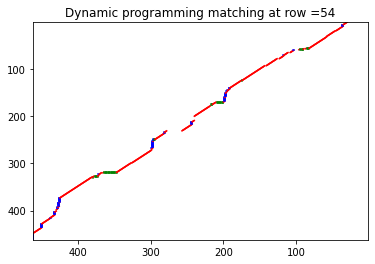

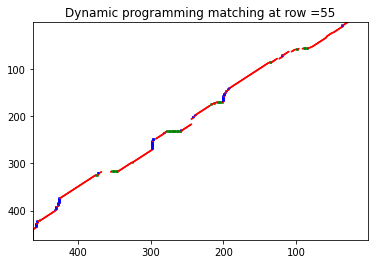

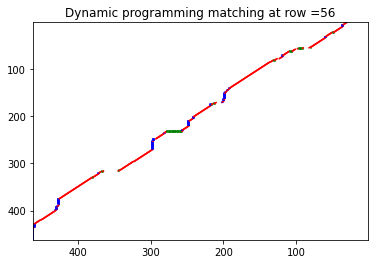

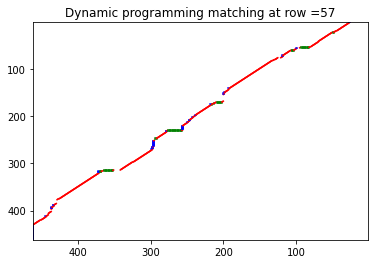

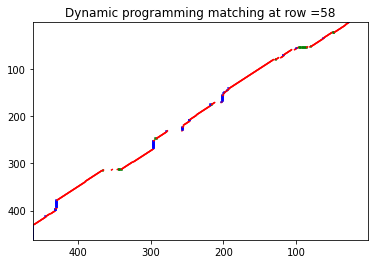

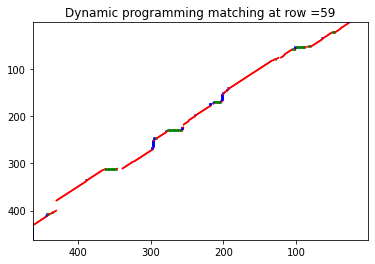

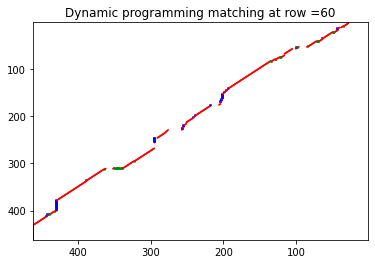

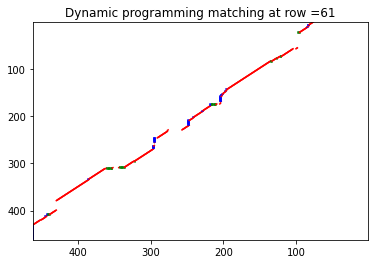

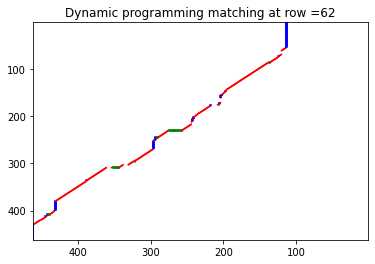

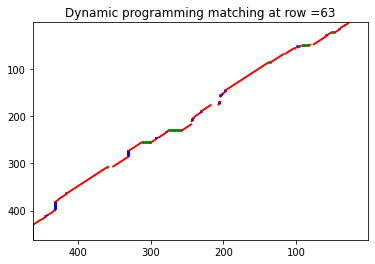

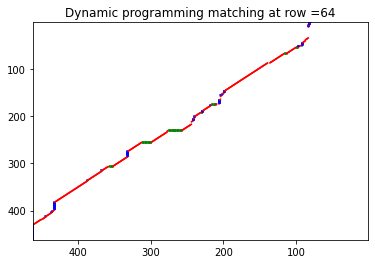

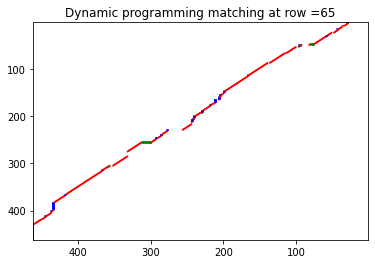

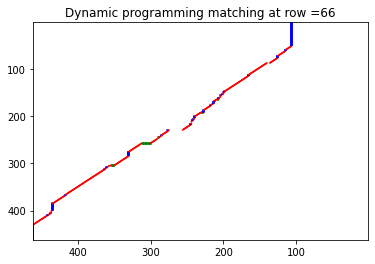

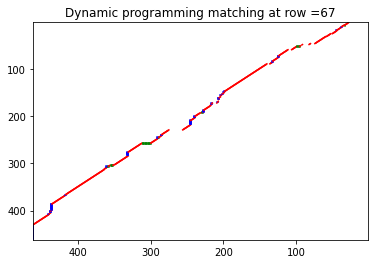

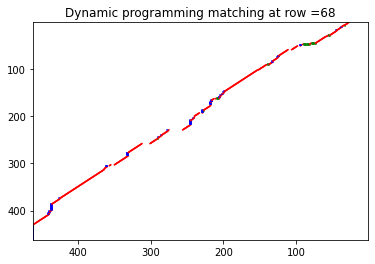

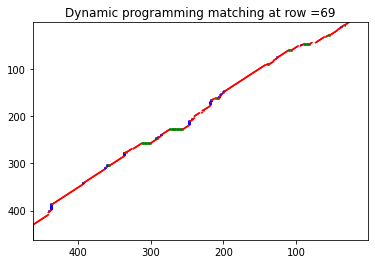

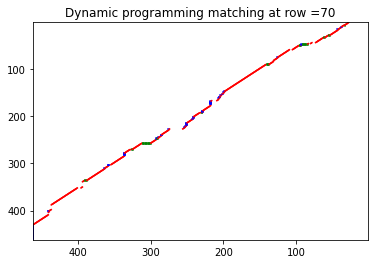

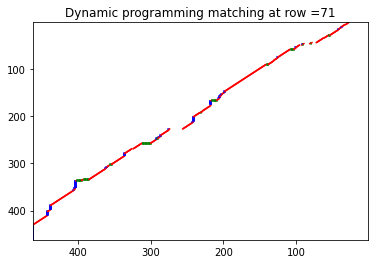

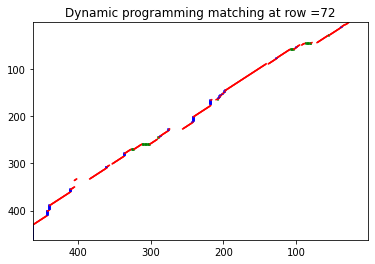

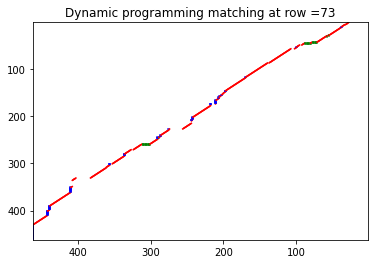

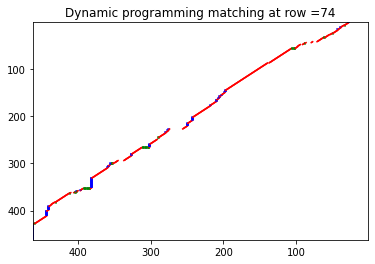

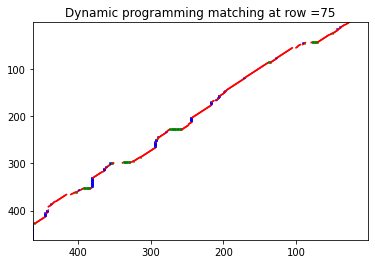

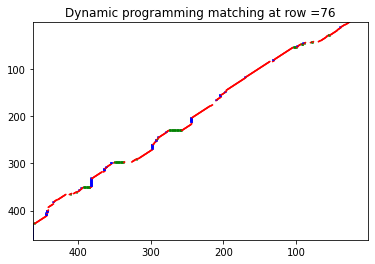

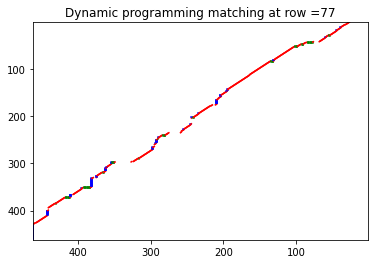

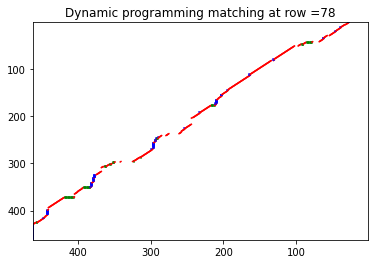

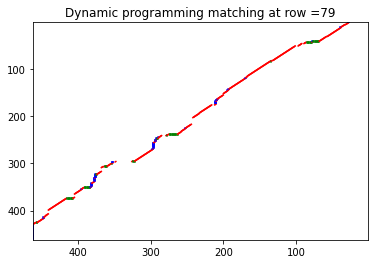

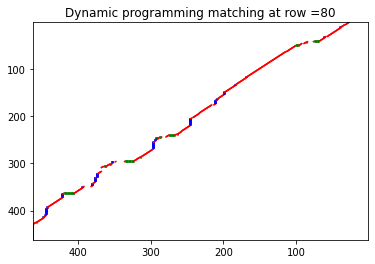

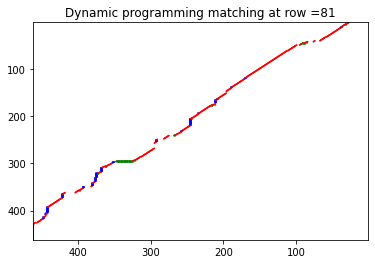

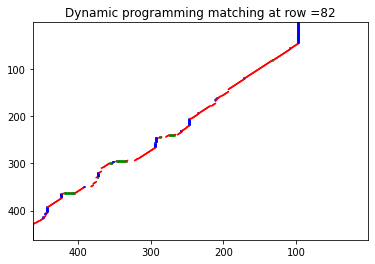

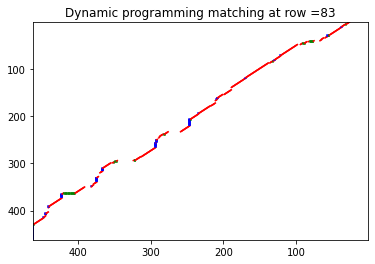

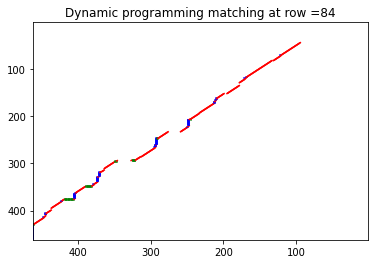

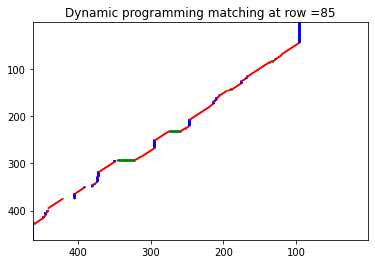

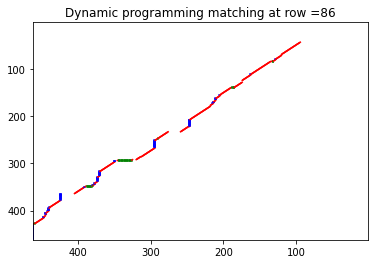

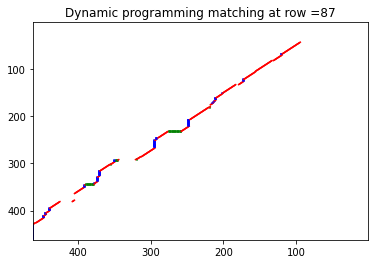

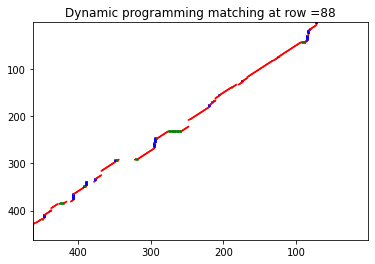

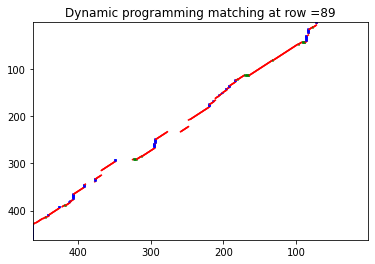

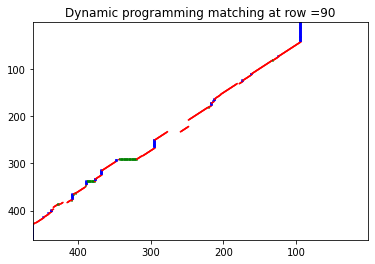

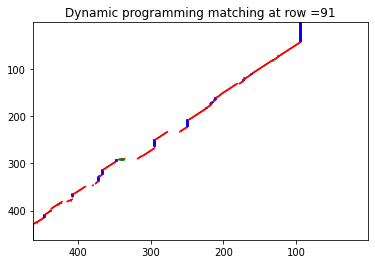

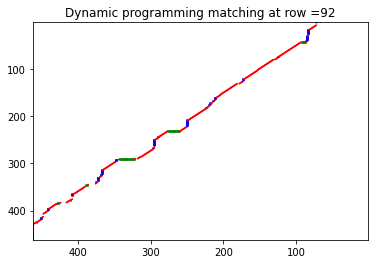

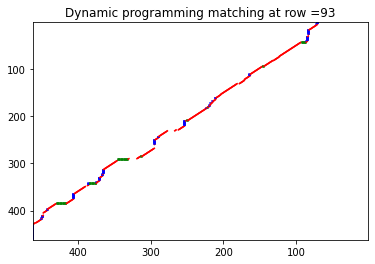

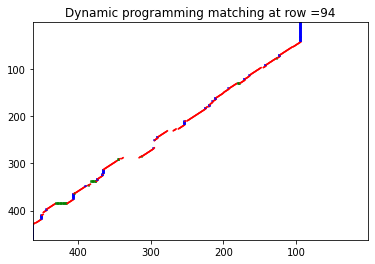

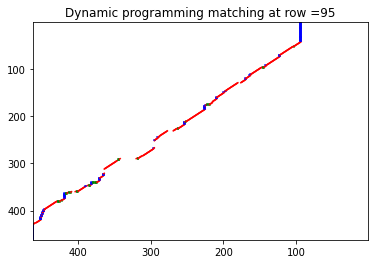

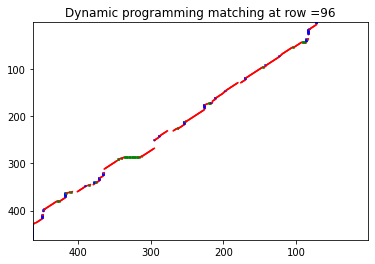

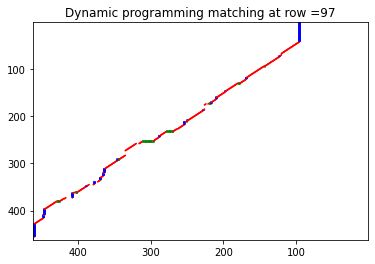

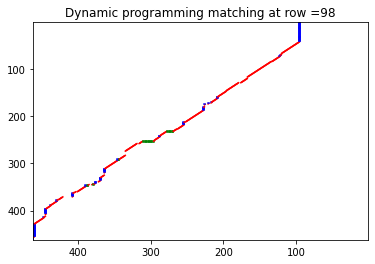

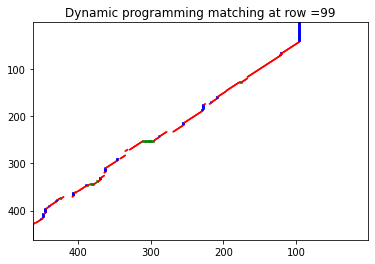

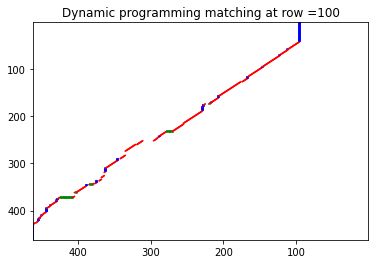

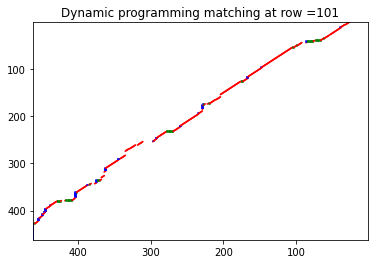

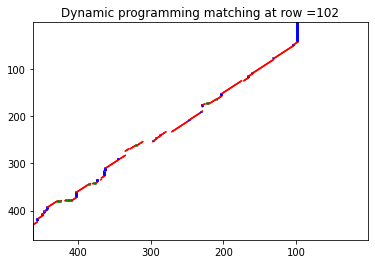

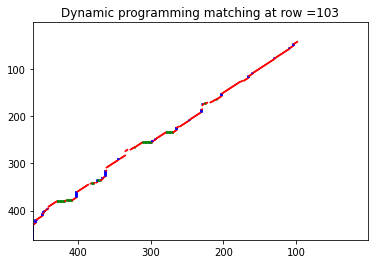

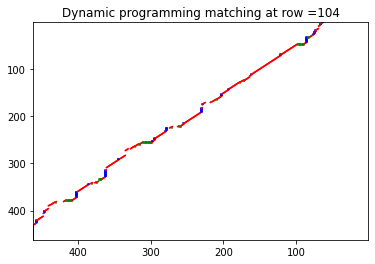

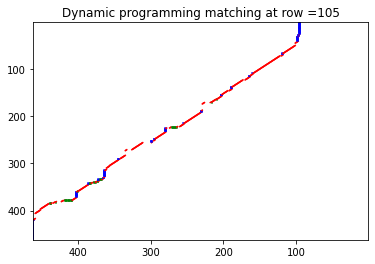

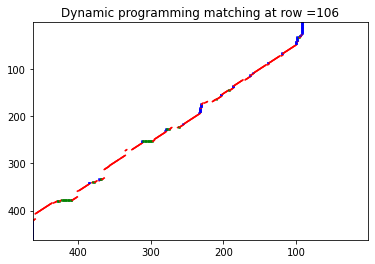

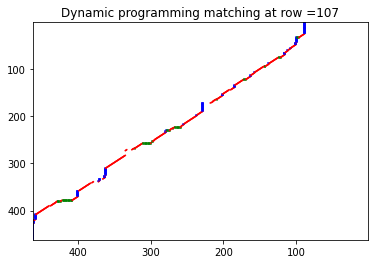

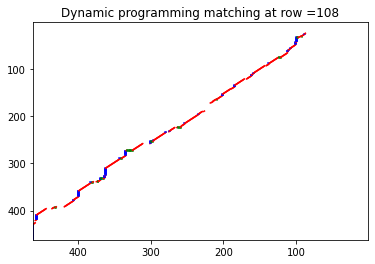

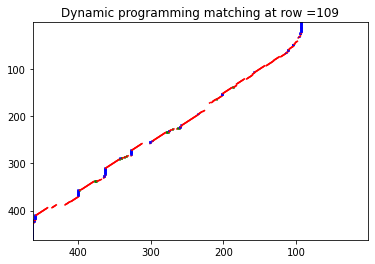

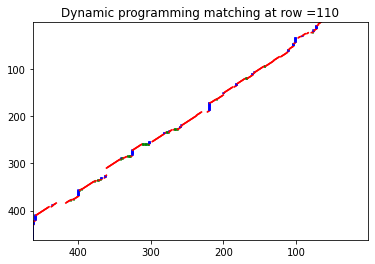

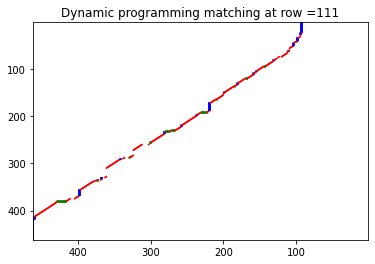

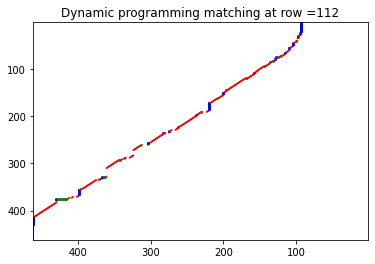

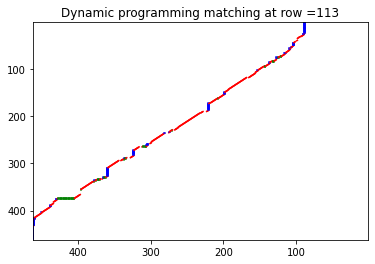

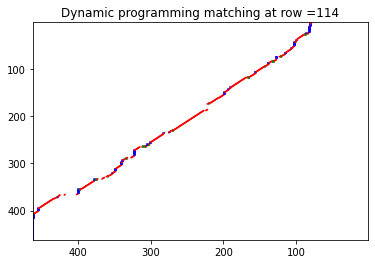

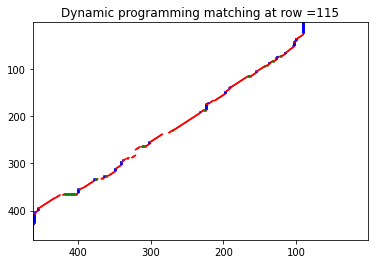

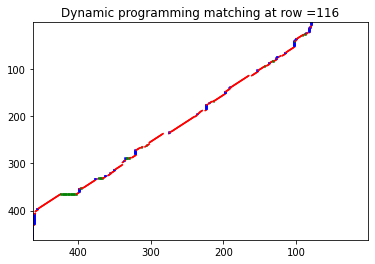

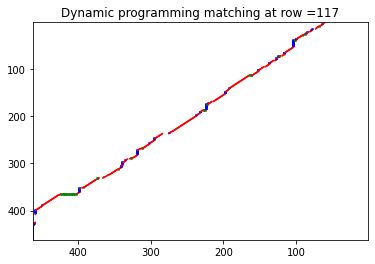

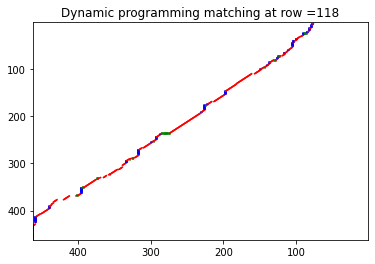

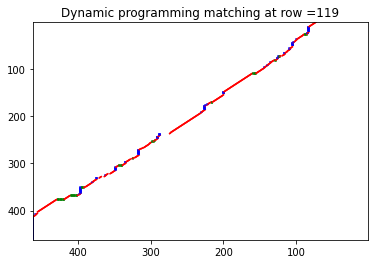

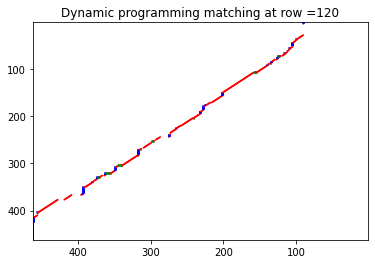

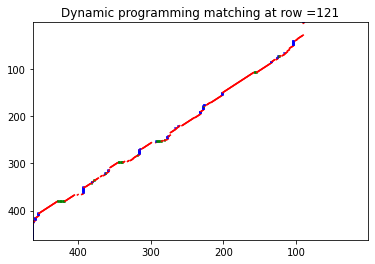

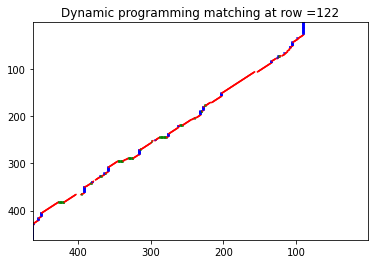

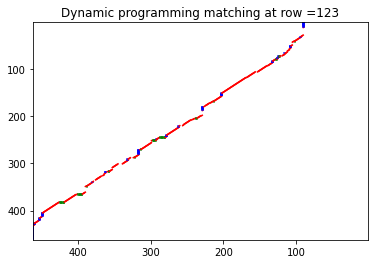

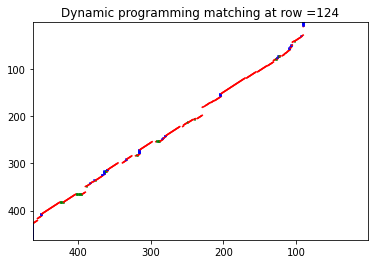

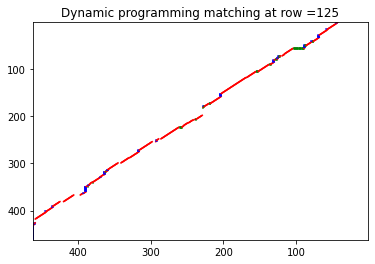

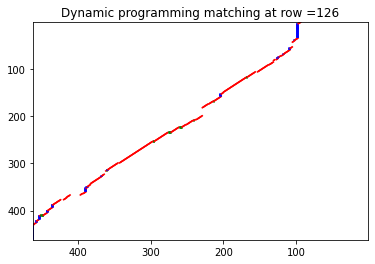

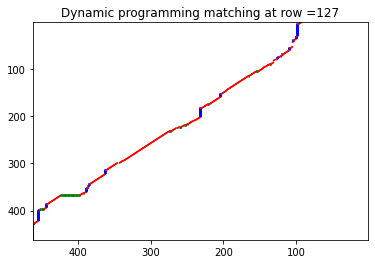

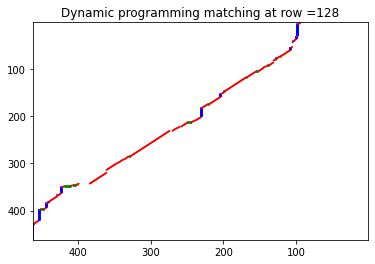

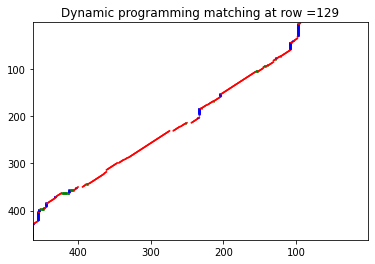

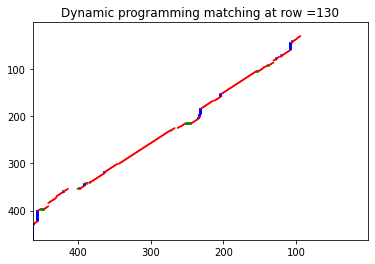

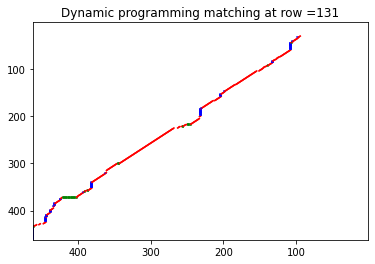

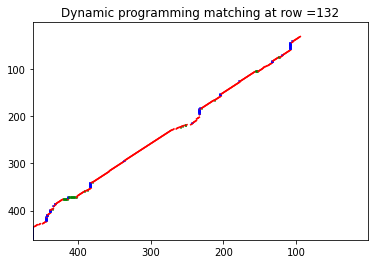

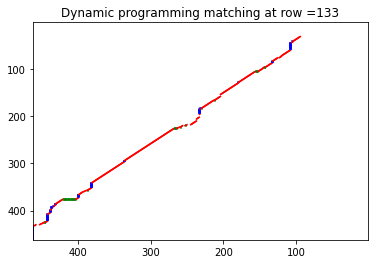

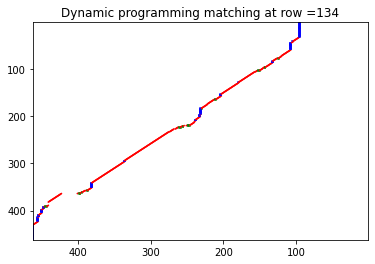

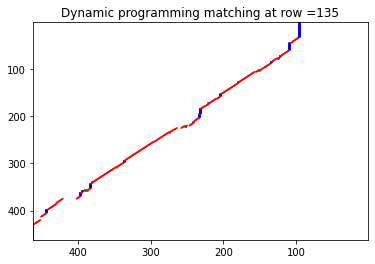

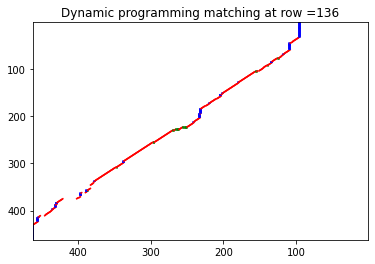

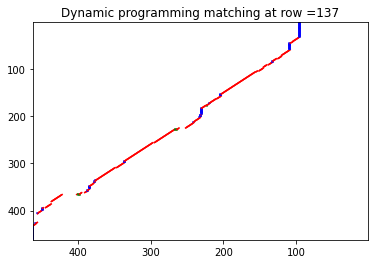

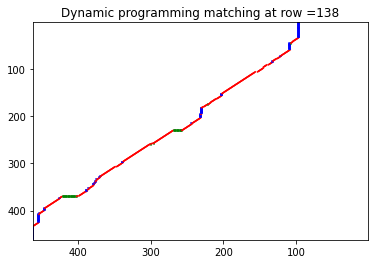

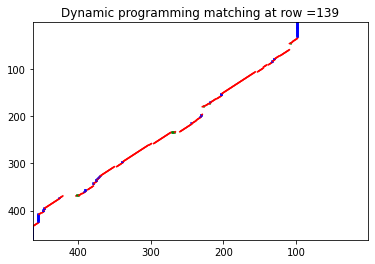

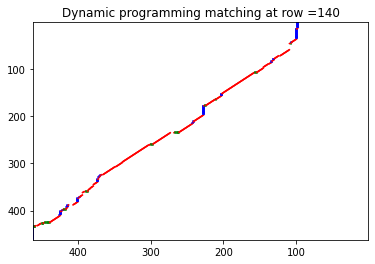

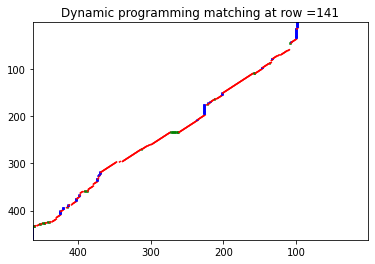

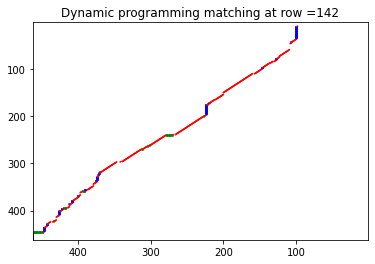

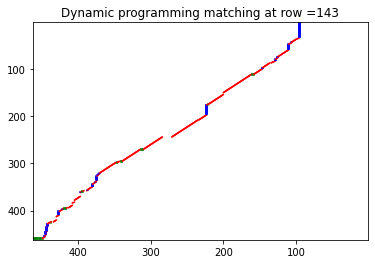

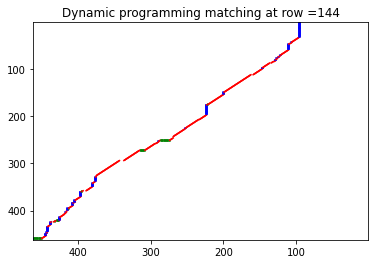

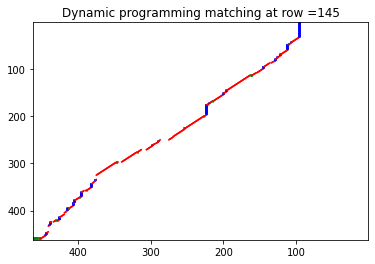

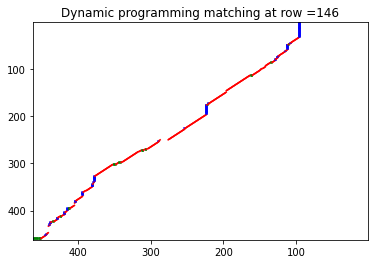

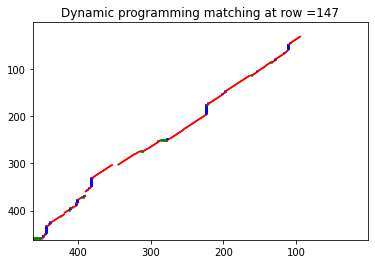

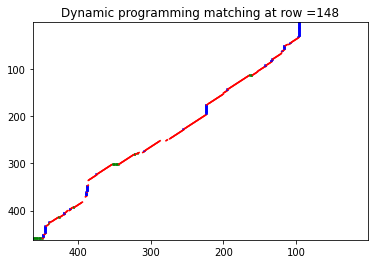

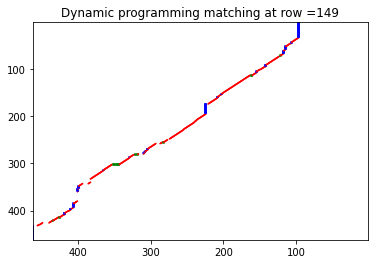

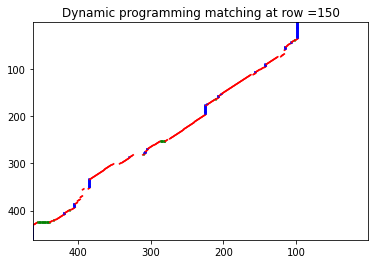

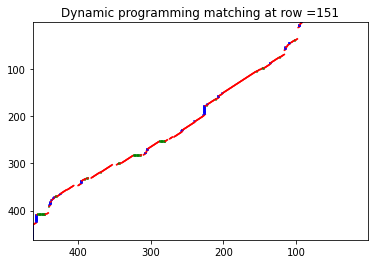

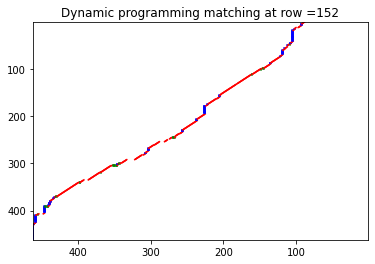

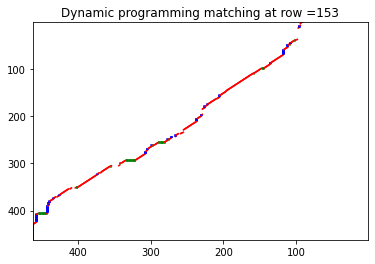

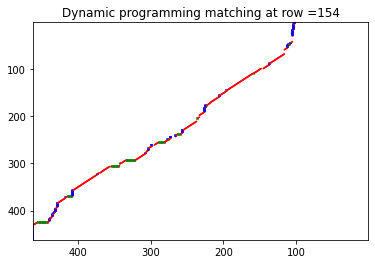

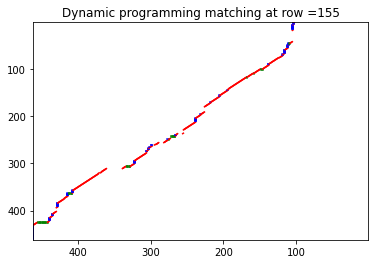

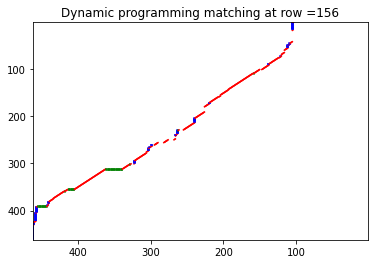

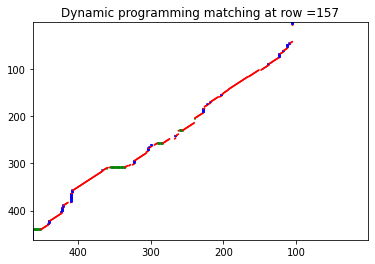

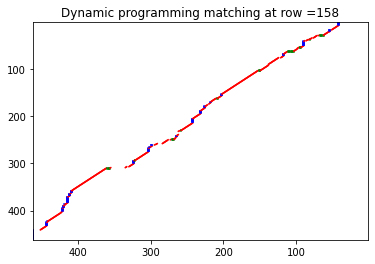

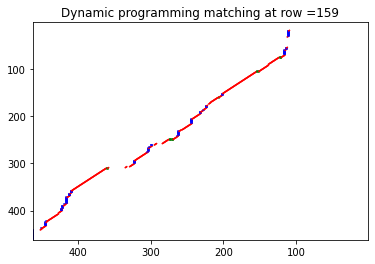

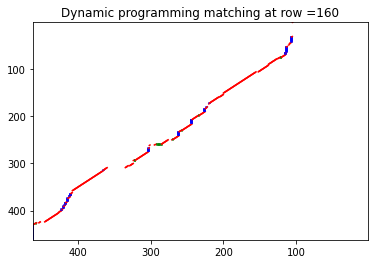

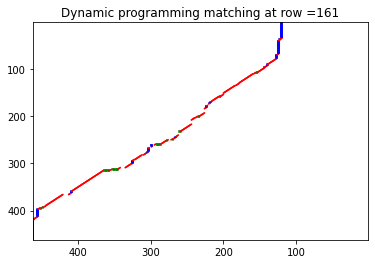

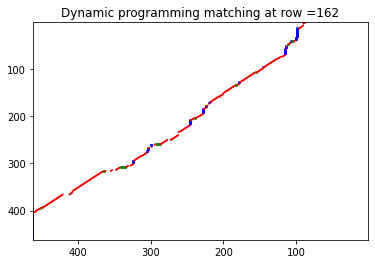

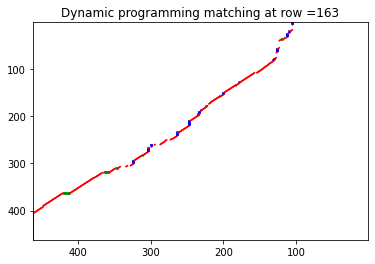

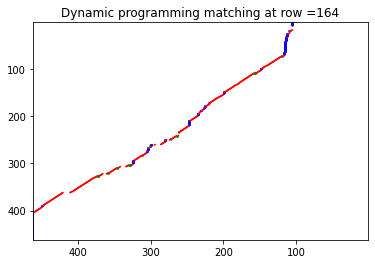

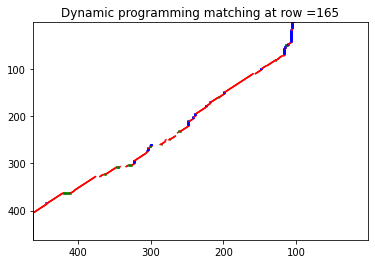

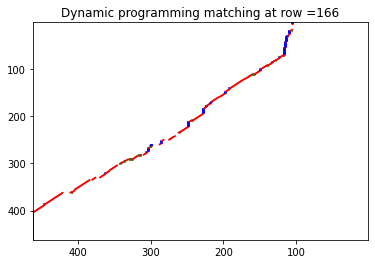

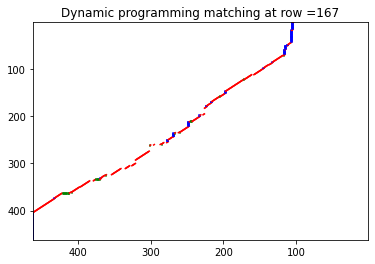

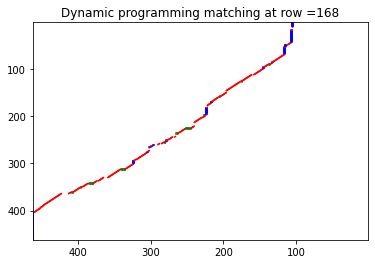

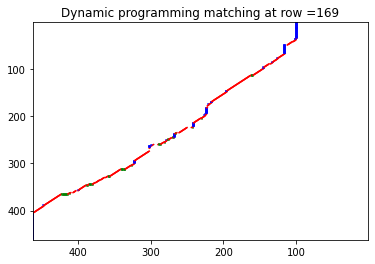

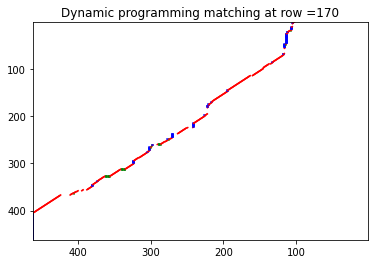

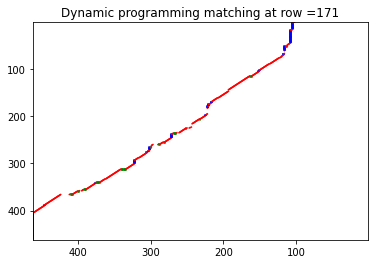

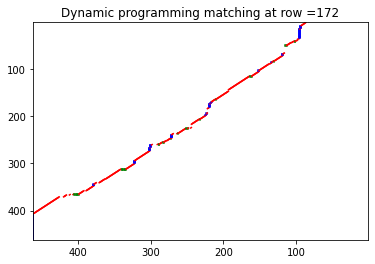

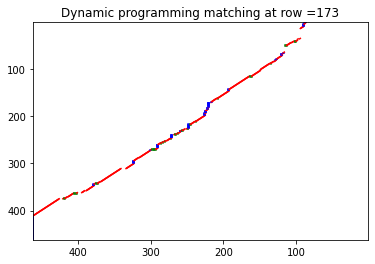

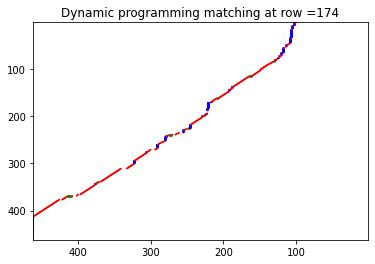

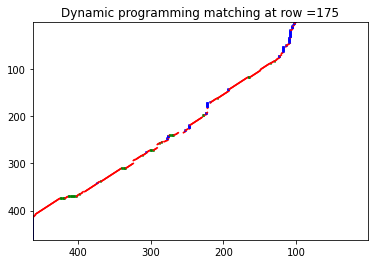

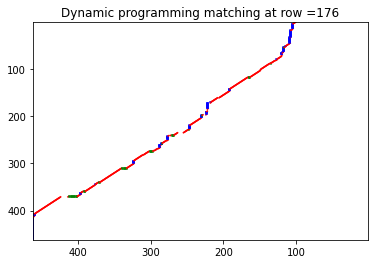

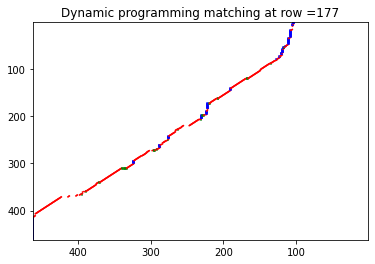

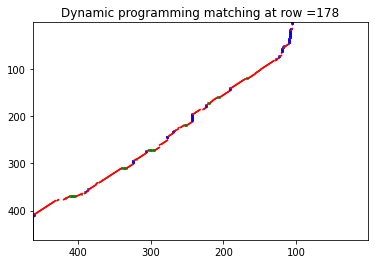

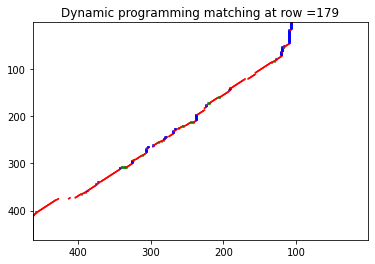

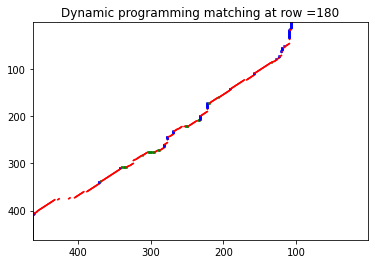

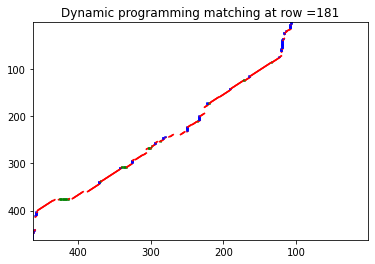

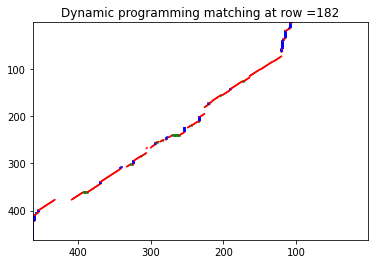

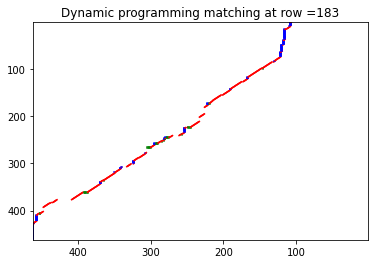

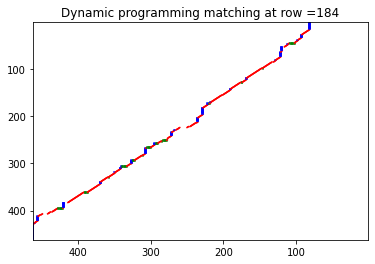

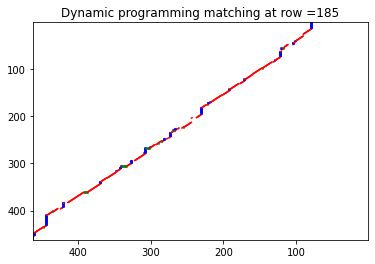

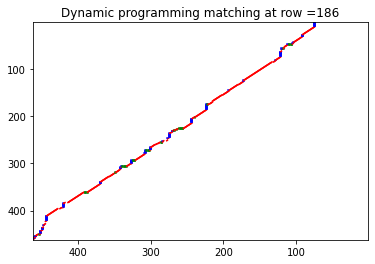

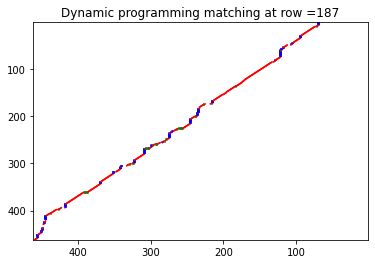

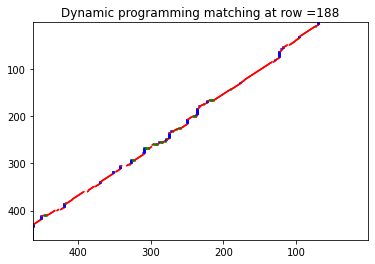

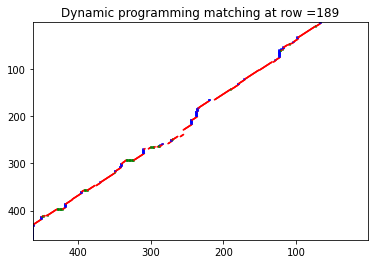

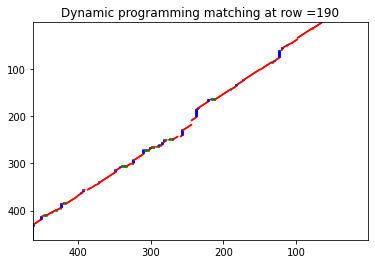

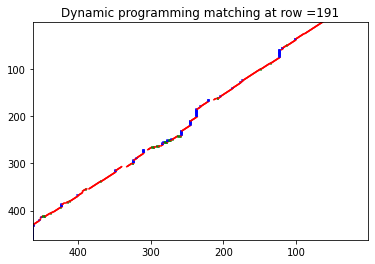

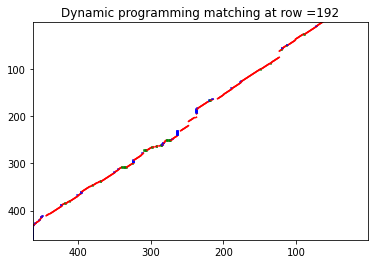

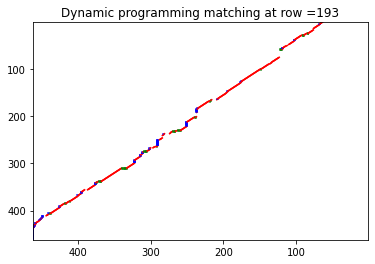

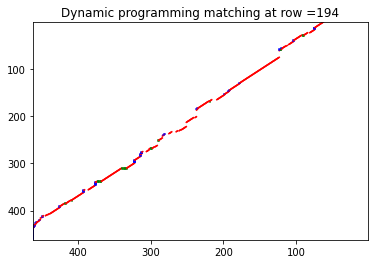

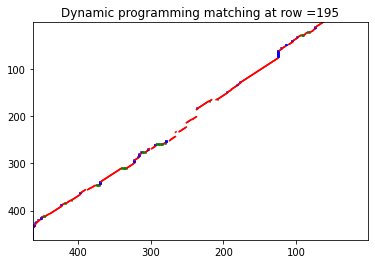

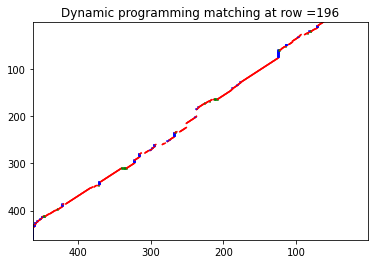

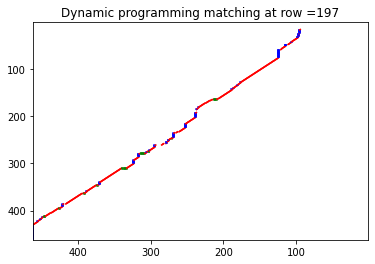

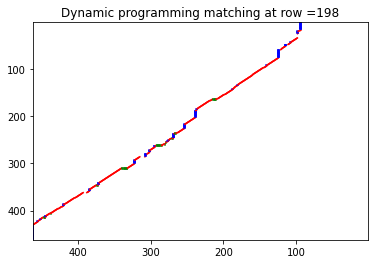

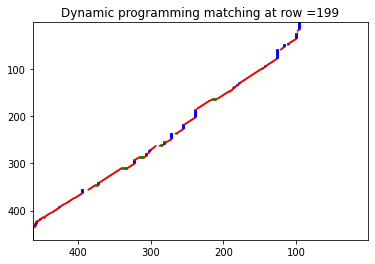

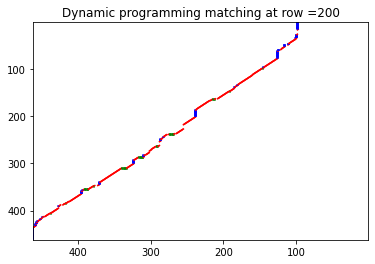

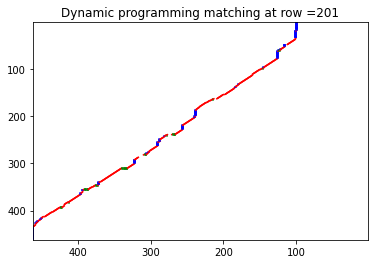

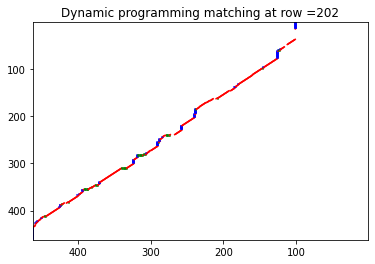

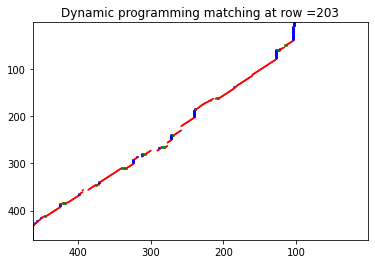

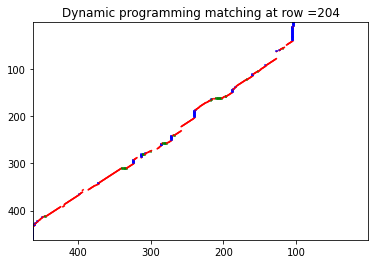

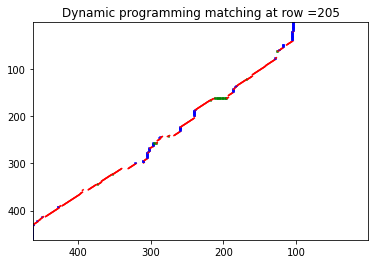

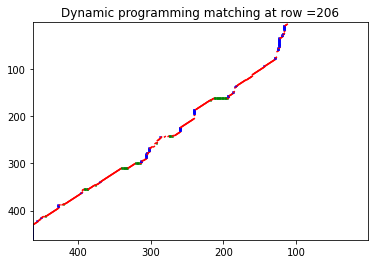

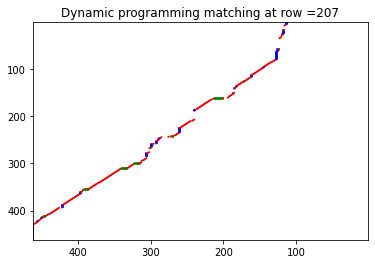

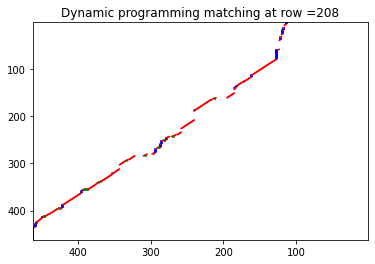

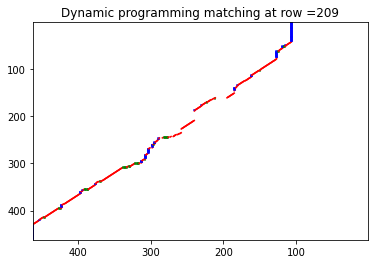

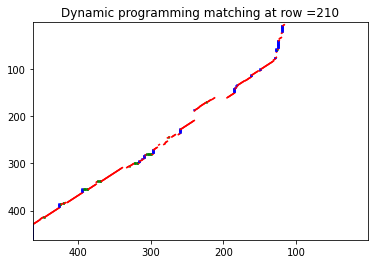

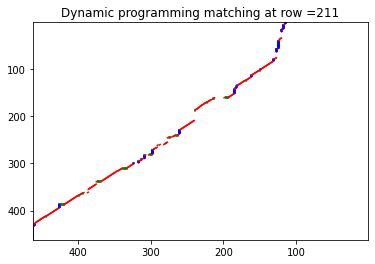

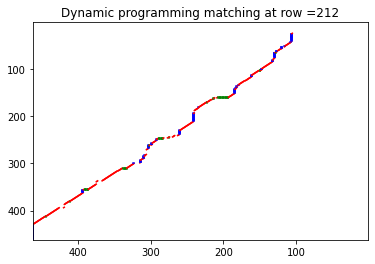

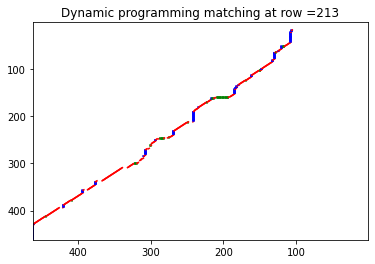

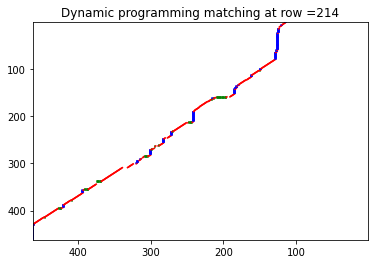

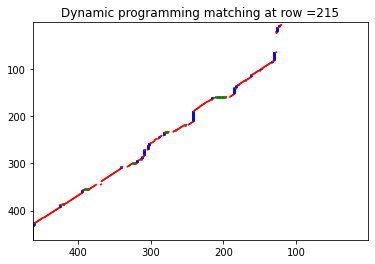

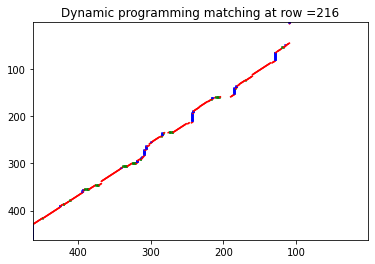

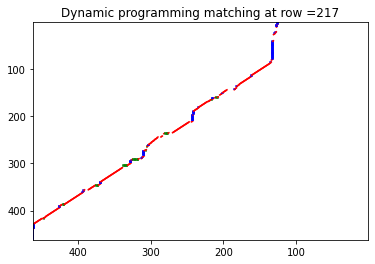

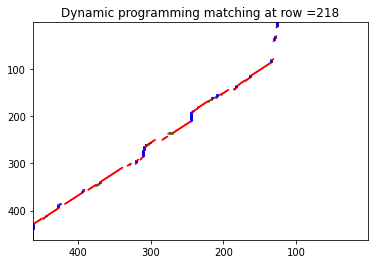

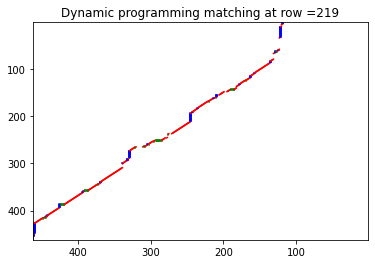

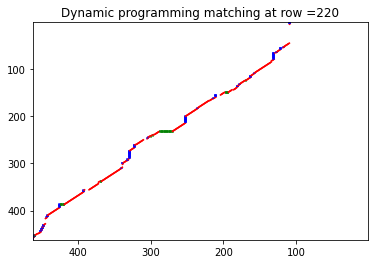

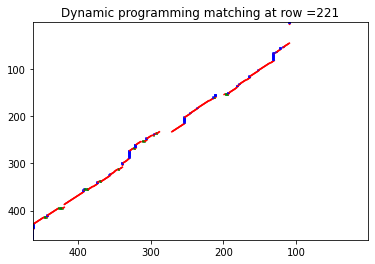

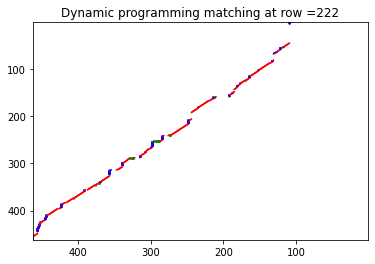

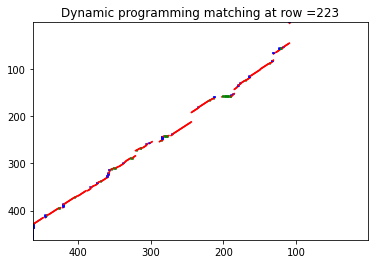

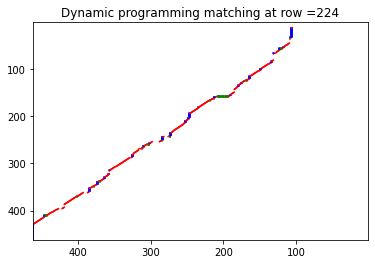

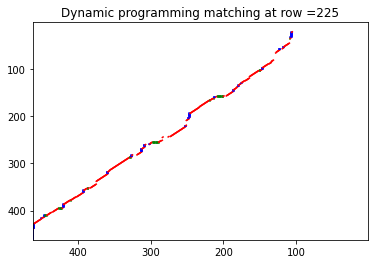

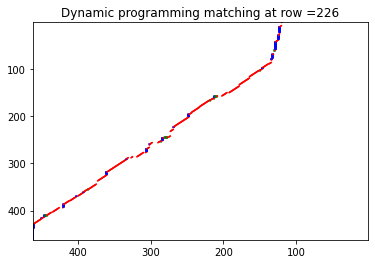

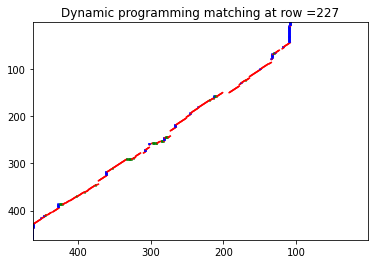

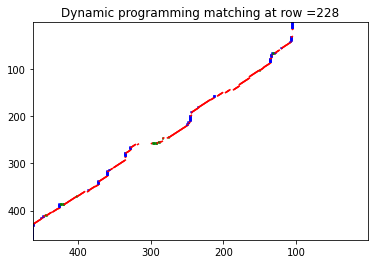

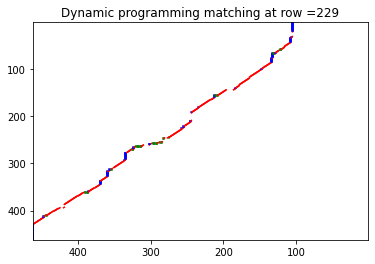

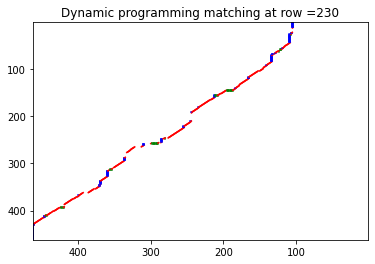

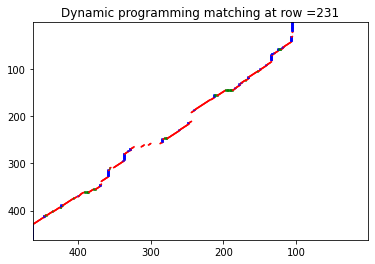

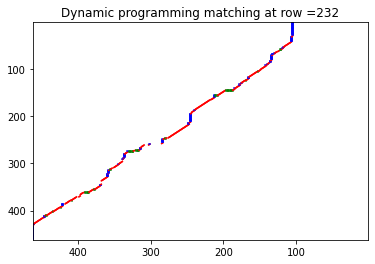

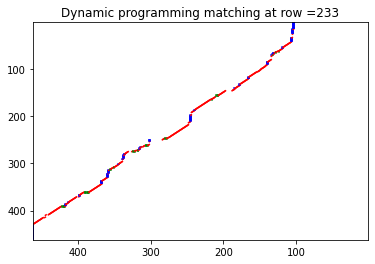

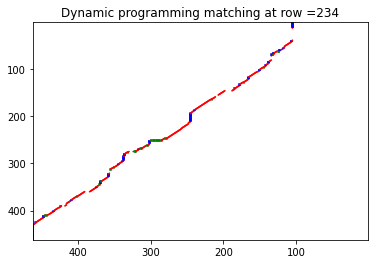

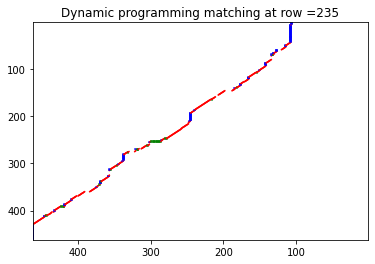

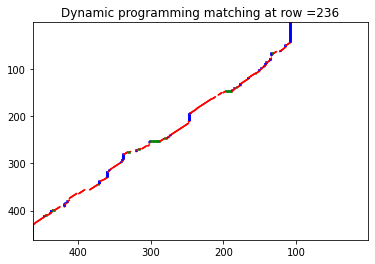

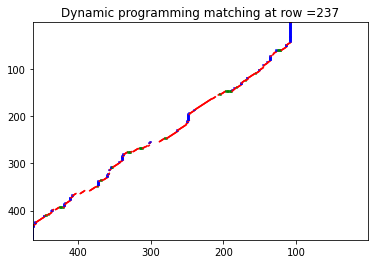

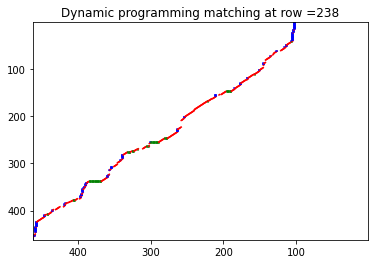

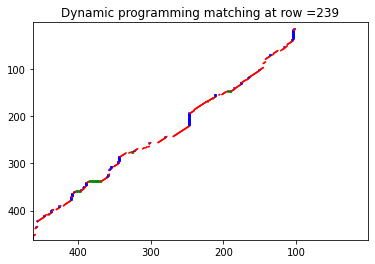

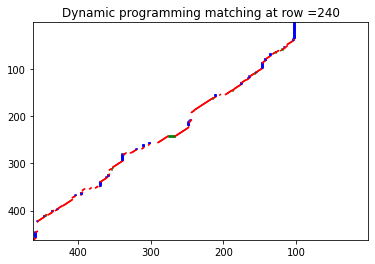

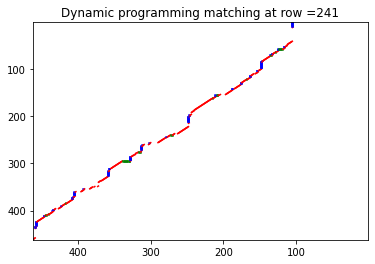

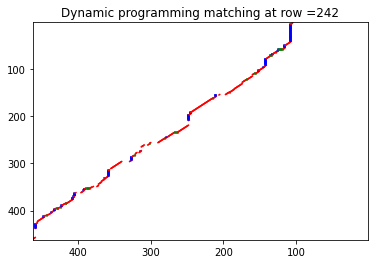

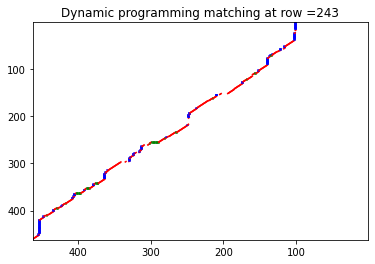

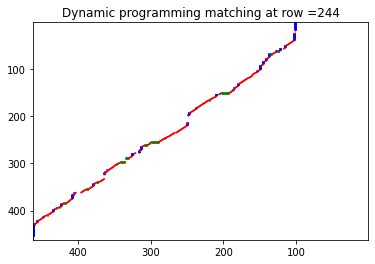

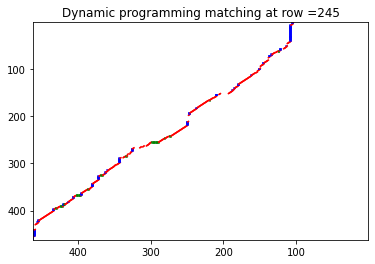

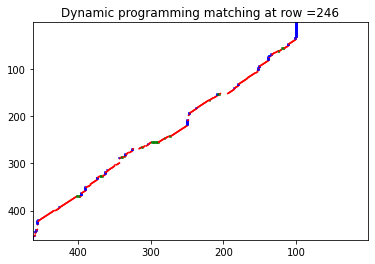

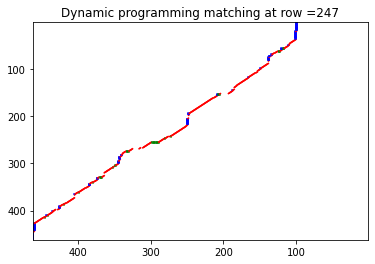

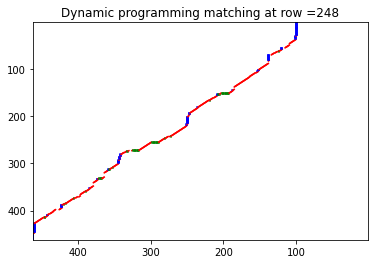

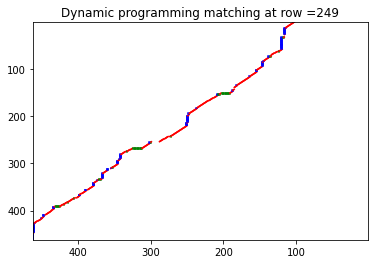

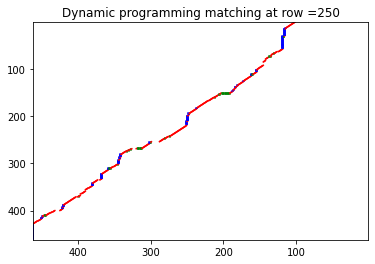

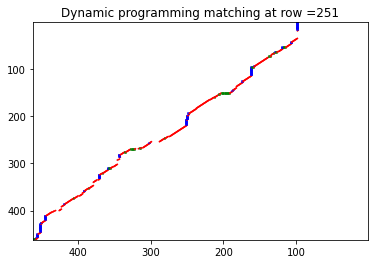

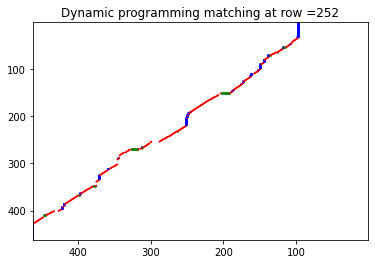

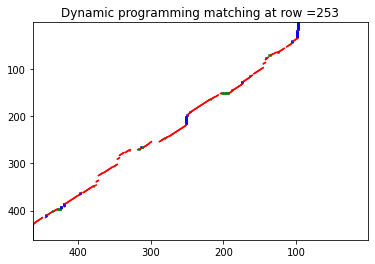

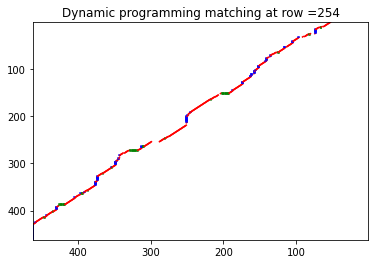

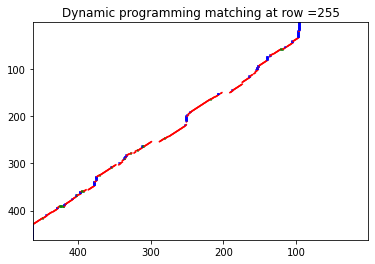

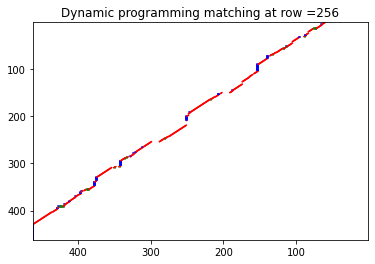

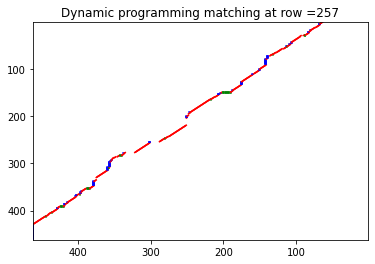

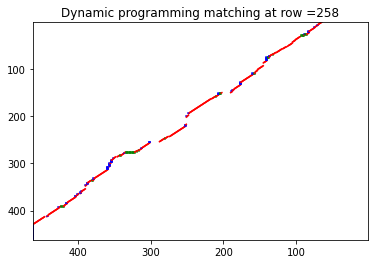

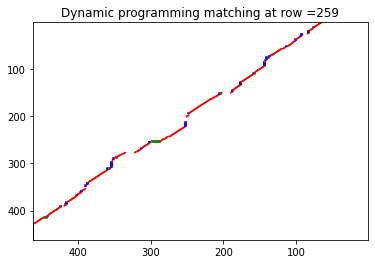

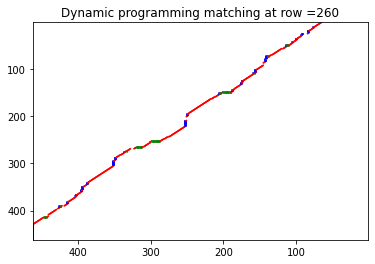

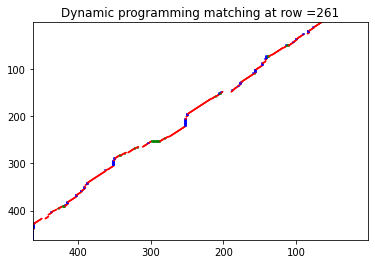

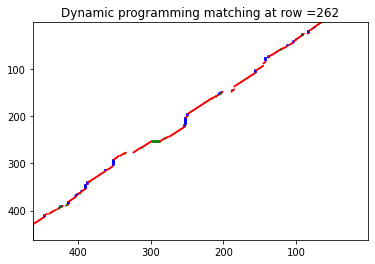

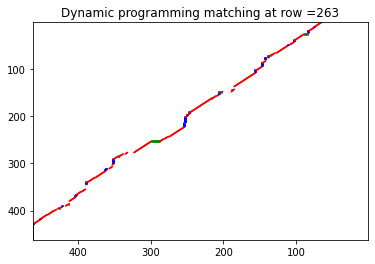

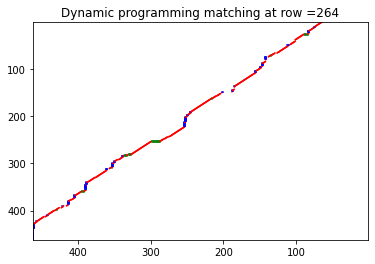

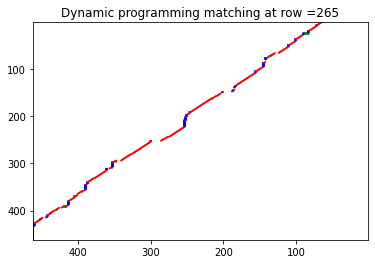

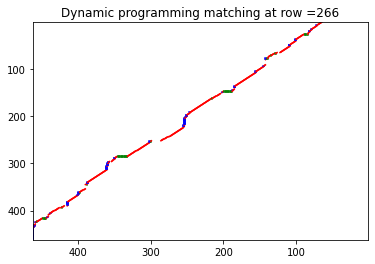

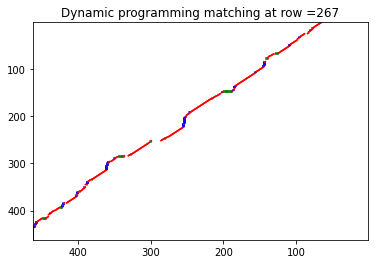

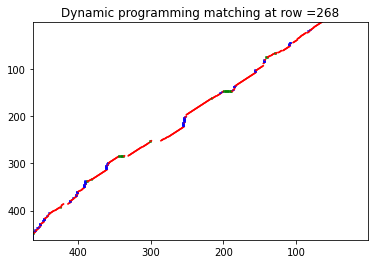

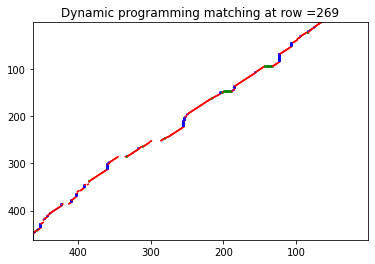

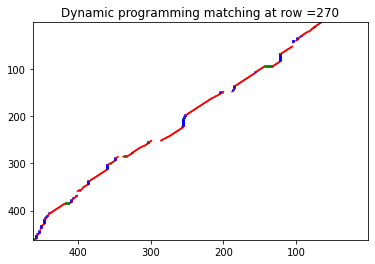

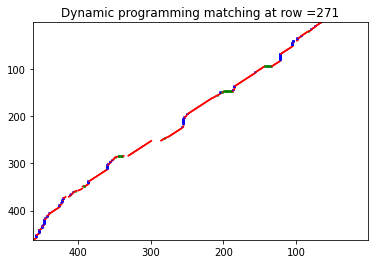

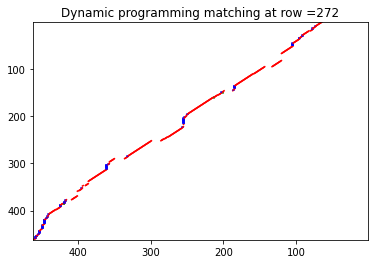

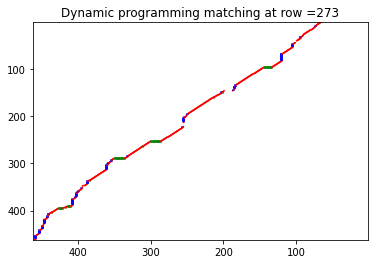

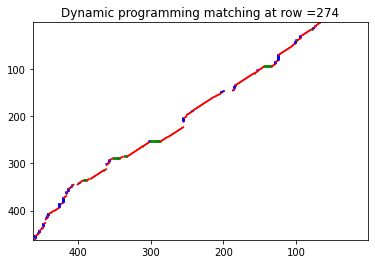

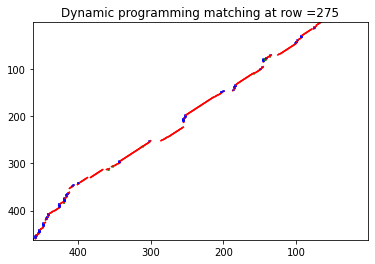

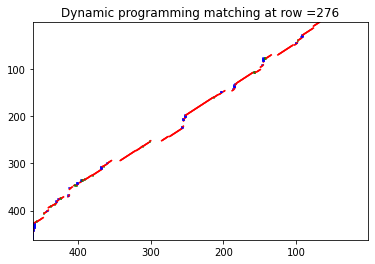

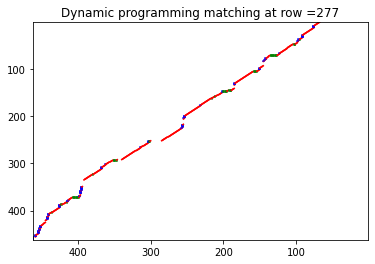

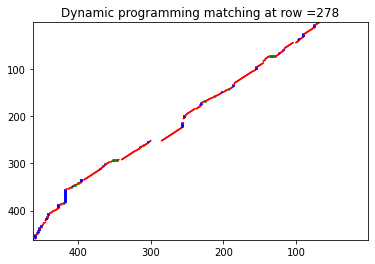

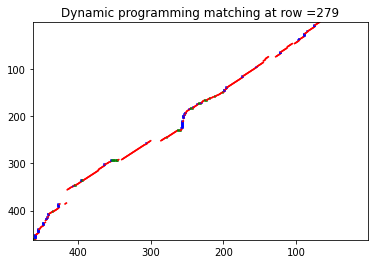

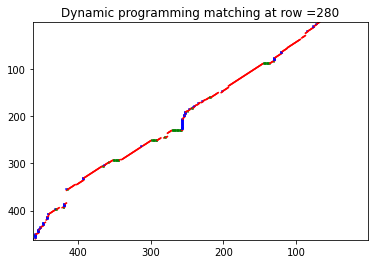

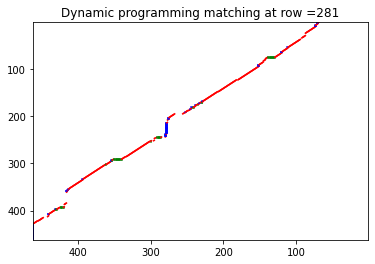

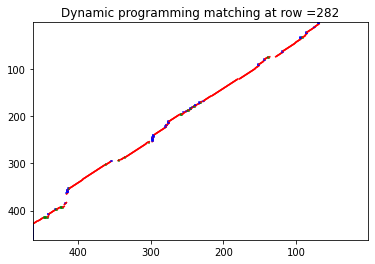

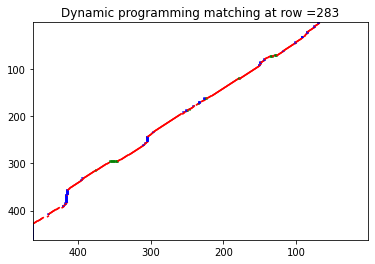

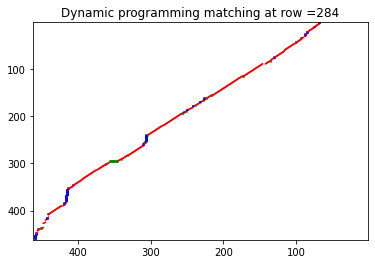

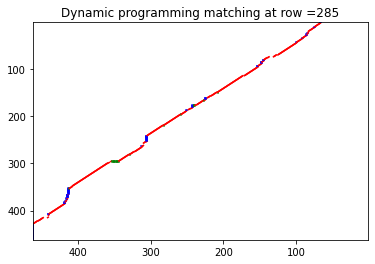

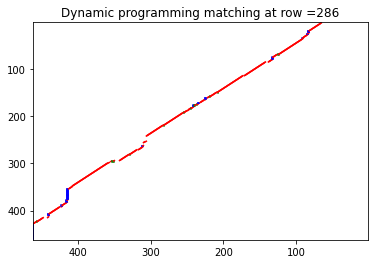

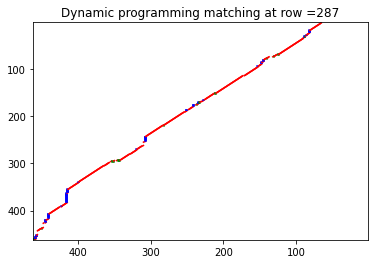

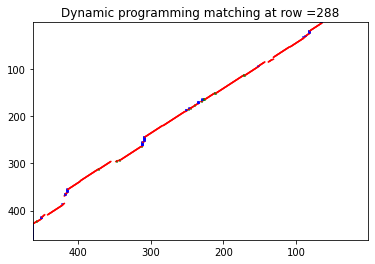

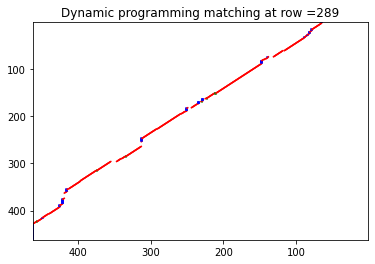

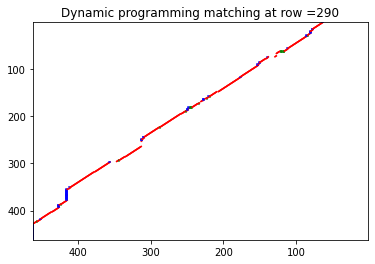

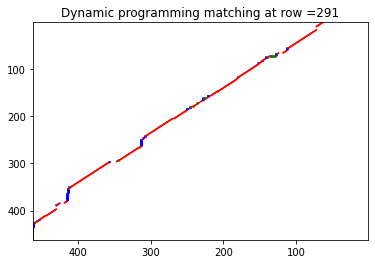

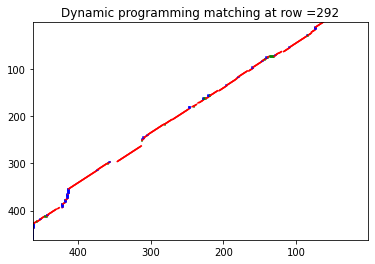

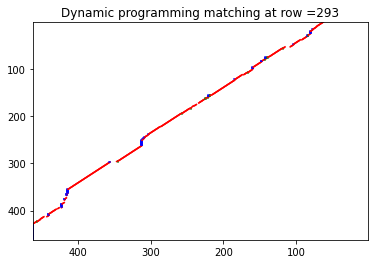

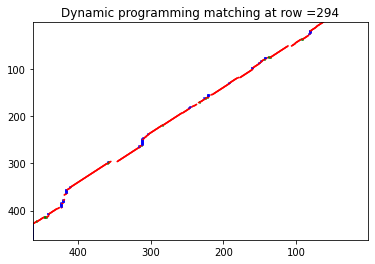

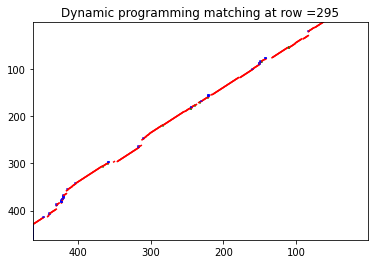

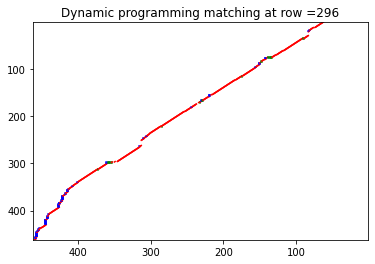

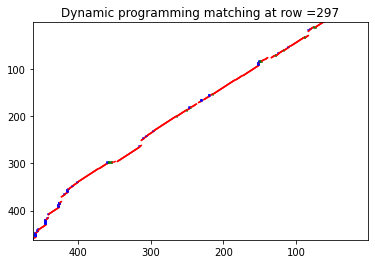

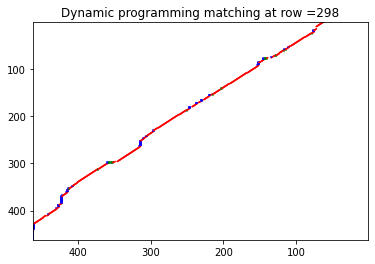

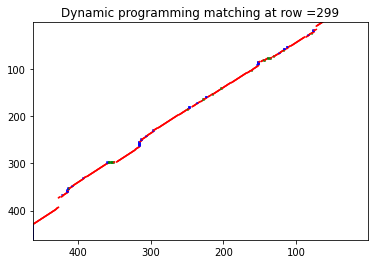

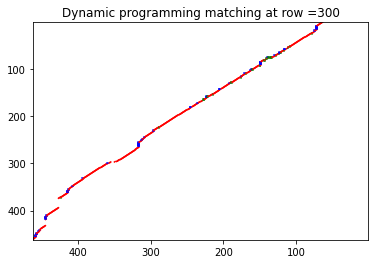

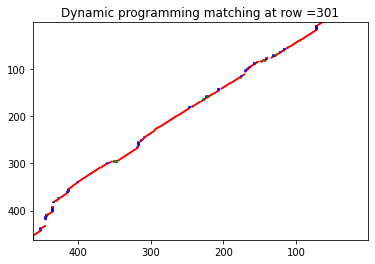

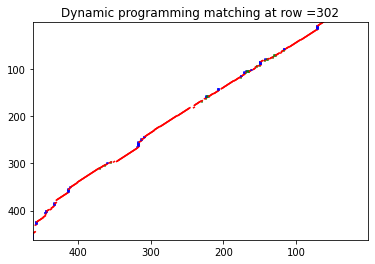

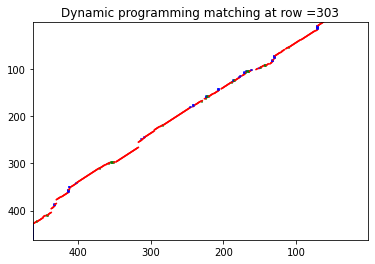

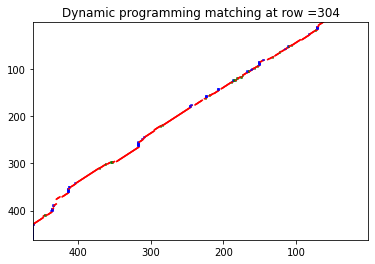

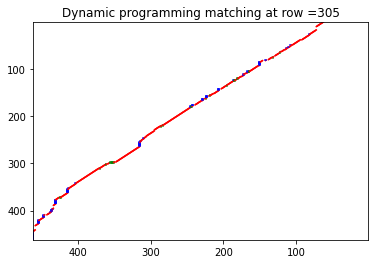

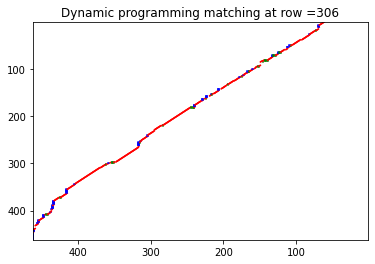

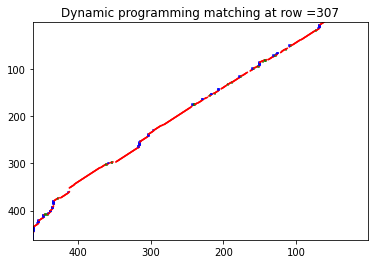

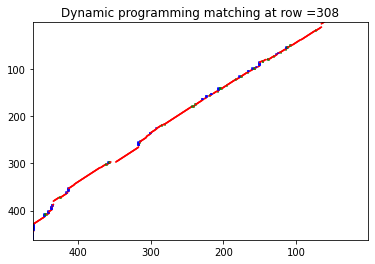

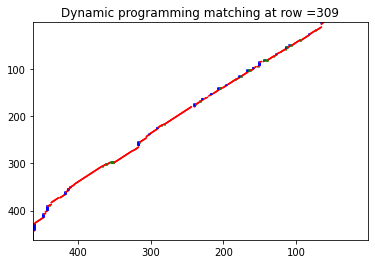

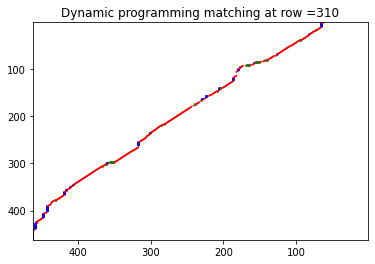

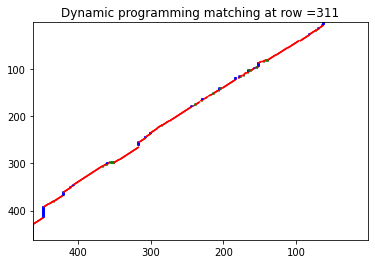

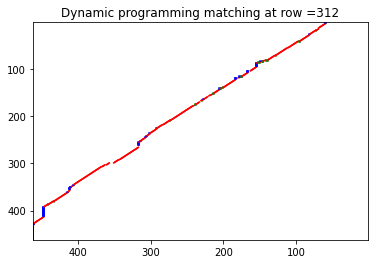

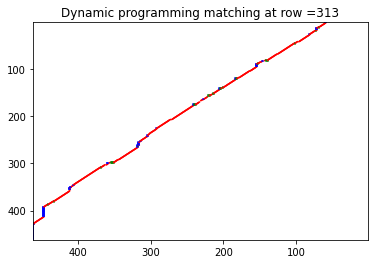

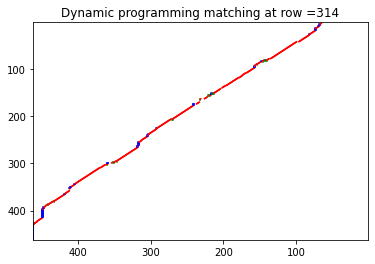

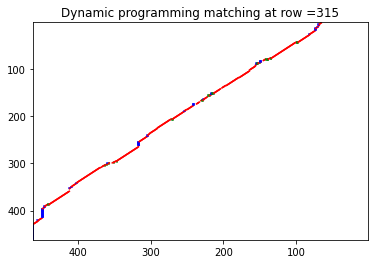

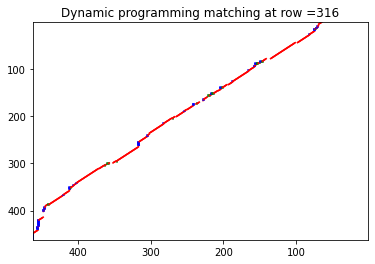

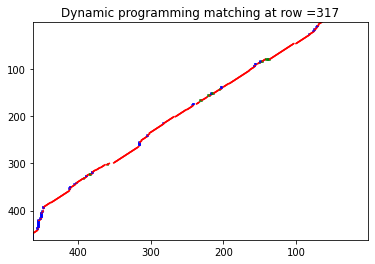

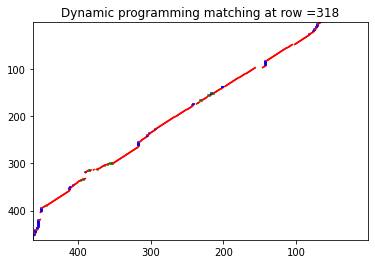

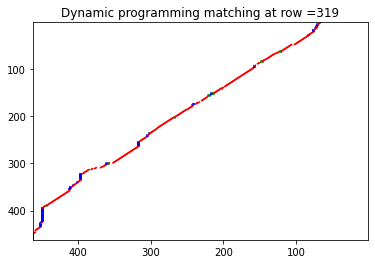

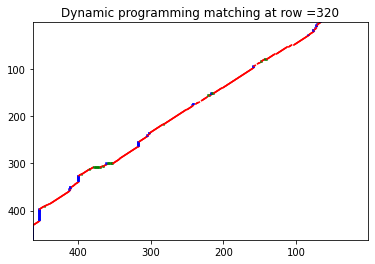

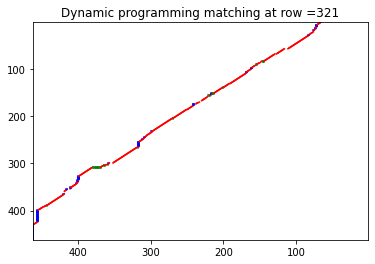

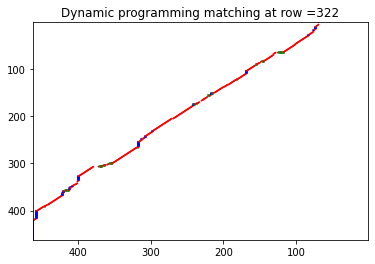

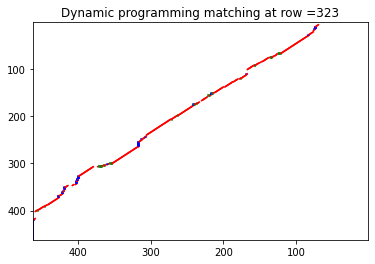

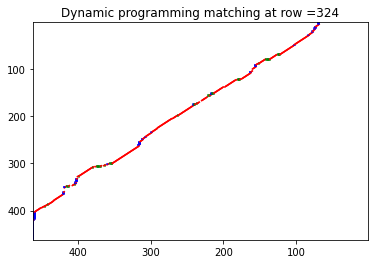

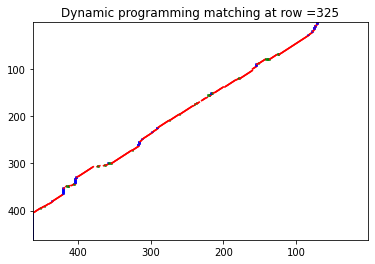

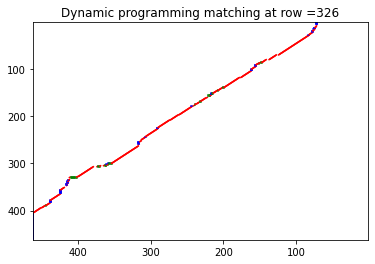

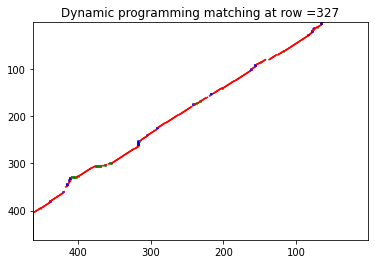

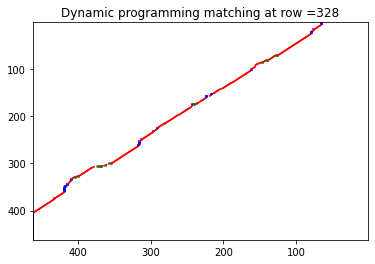

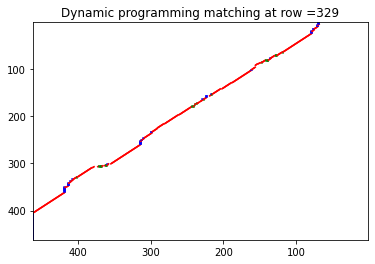

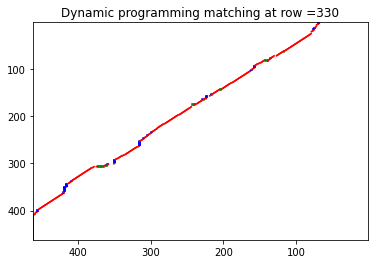

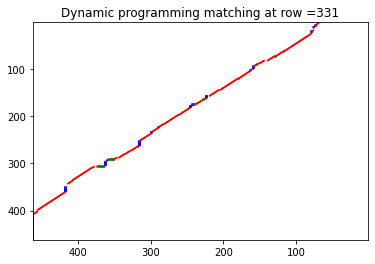

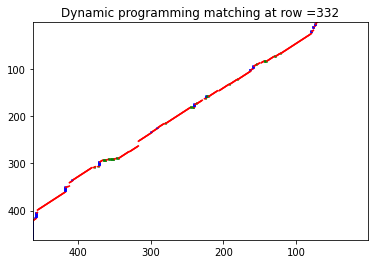

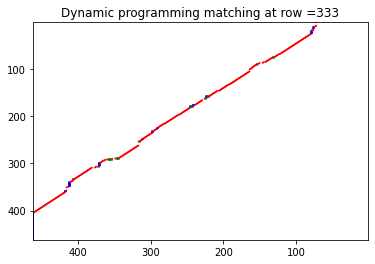

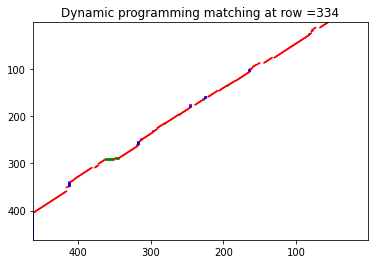

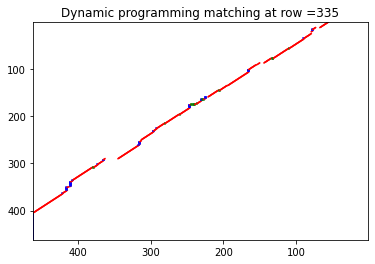

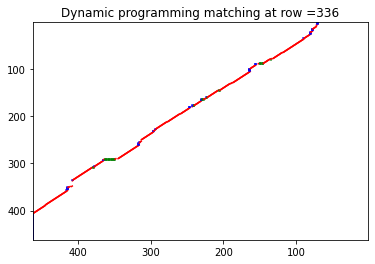

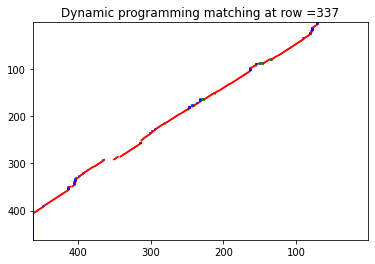

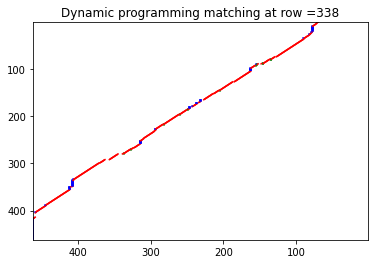

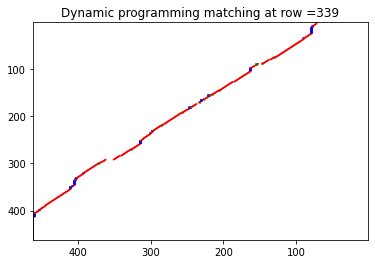

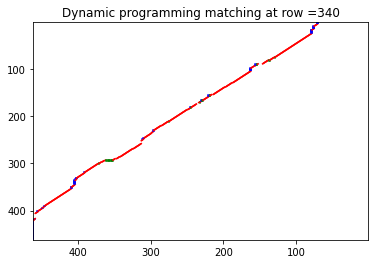

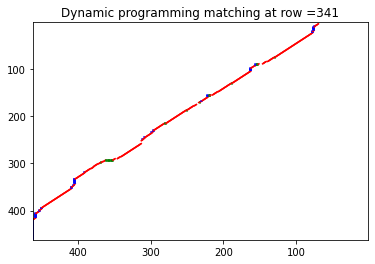

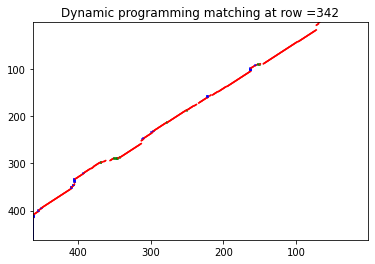

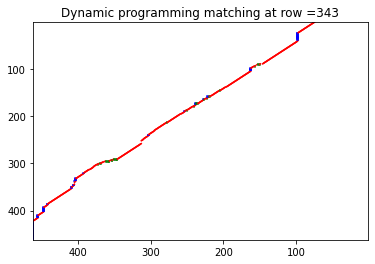

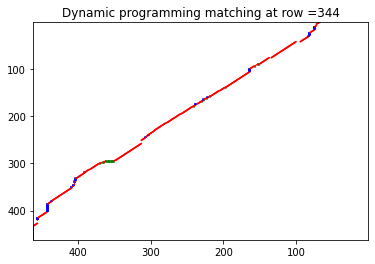

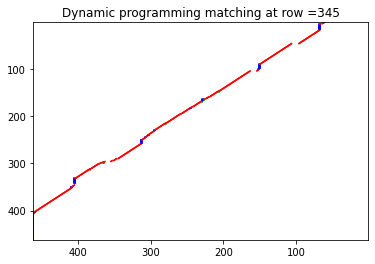

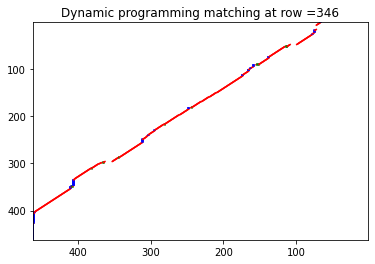

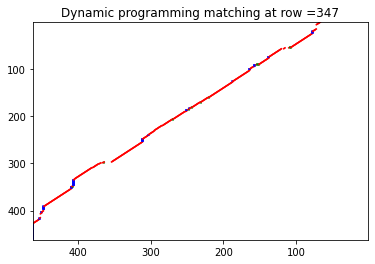

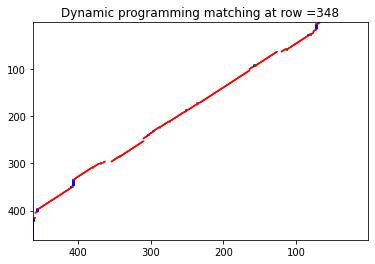

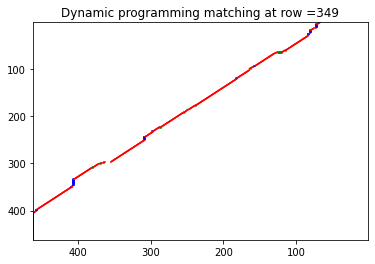

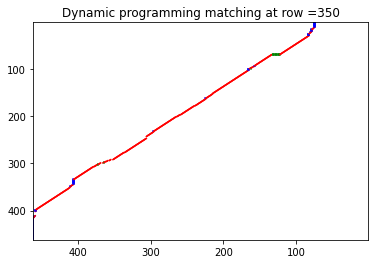

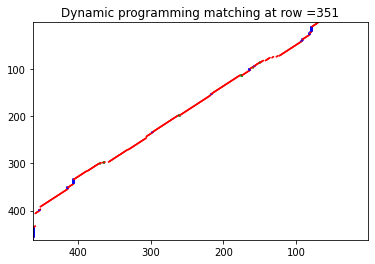

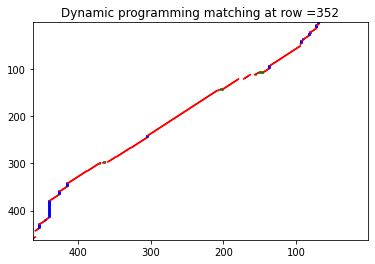

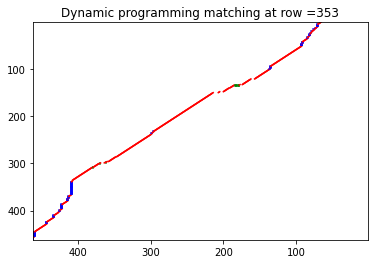

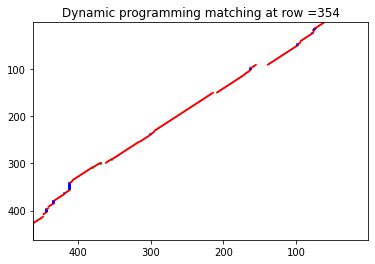

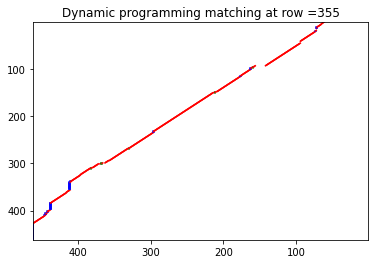

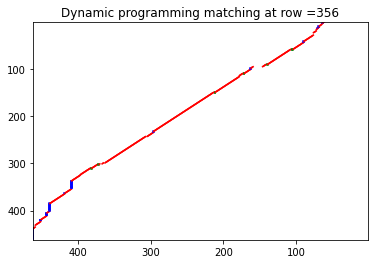

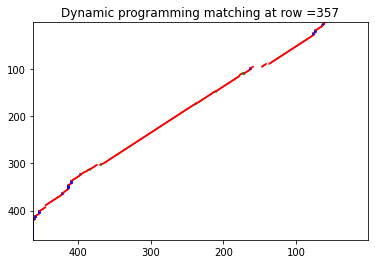

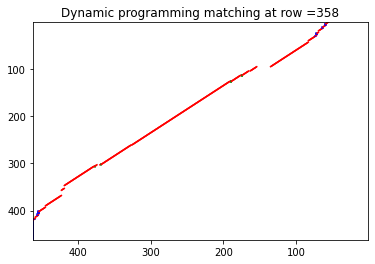

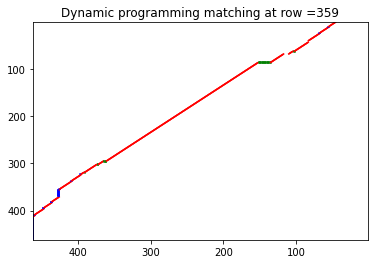

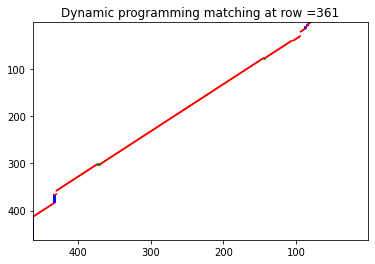

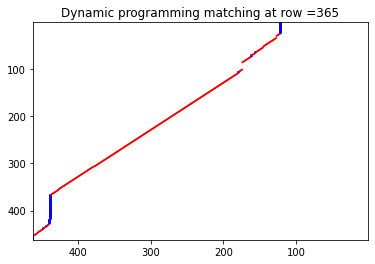

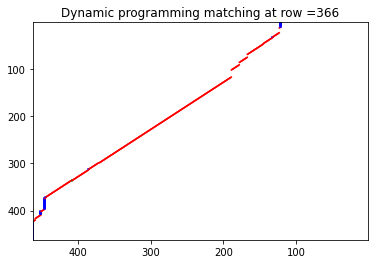

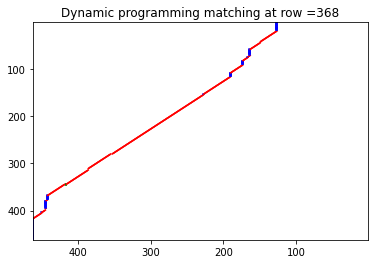

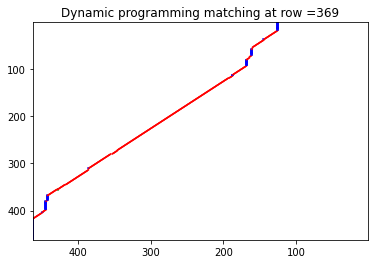

<Figure size 432x288 with 0 Axes>

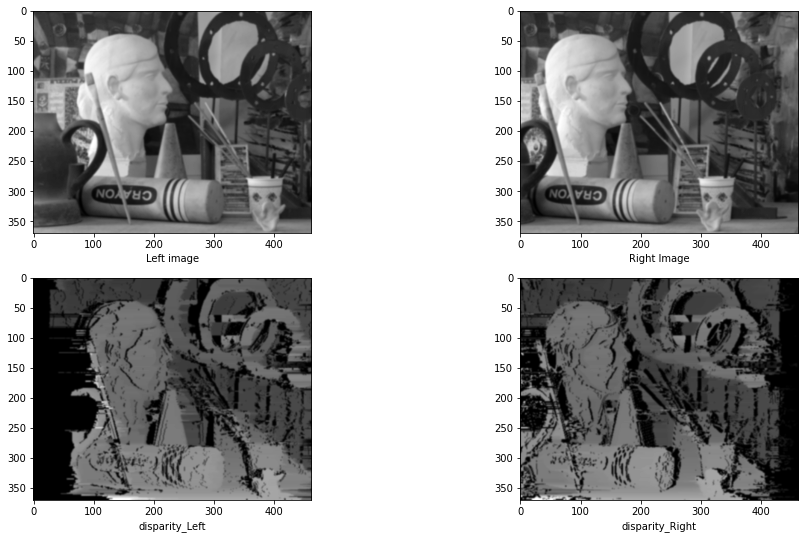

In [ ]:
img1,img2 = load_images(img1_path,img2_path)
disparity_Left,disparity_Right = get_disparity(img1,img2)
show_results(img1,img2,disparity_Left,disparity_Right)